In [1]:
# !pip install sciann fteikpy pyDOE -q 

In [2]:
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
PATH_NAME = "EnDeepONet_SmoothVelocity"

In [4]:
import numpy as np
import sciann as sn 
import matplotlib.pyplot as plt

%matplotlib inline

---------------------- SCIANN 0.7.0.0 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.8.4 
Python Version: 3.8.16 (default, Jan 17 2023, 23:13:24) 
[GCC 11.2.0] 

Outdated SciANN installation is found (V-0.7.0.0). Get the latest version (V-0.7.0.1):  
      > pip [--user] install --upgrade sciann  


In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

2023-05-21 08:38:58.318581: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 08:38:58.346480: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-21 08:38:58.346518: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ehaghighatg4
2023-05-21 08:38:58.346525: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ehaghighatg4
2023-05-21 08:38:58.346667: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 455.23.5
2023-05-21 08:38:58.346690: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported v

''

# Testing different velocity models 

In [6]:
import skfmm
from scipy.interpolate import griddata

class EikonalSolver:
    def __init__(self, xd = [-1.0, 1.0],
                       yd = [-1.0, 1.0],
                       vel = np.ones((10, 10)),
                       source = [0.0, 0.0]):
        self.origin = (xd[0], yd[0])
        Nx, Ny = [n - 1 for n in vel.shape]
        dx, dy = (xd[1]-xd[0])/(Nx), (yd[1]-yd[0])/(Ny)
        sx, sy = np.round((source[0] - xd[0])/dx).astype(int), np.round((source[1] - yd[0])/dy).astype(int)
        phi = np.ones_like(vel)
        phi[sx, sy] = -1
        self.nx = (Nx+1, Ny+1)
        self.xg = np.meshgrid(np.linspace(xd[0], xd[1], Nx+1), np.linspace(yd[0], yd[1], Ny+1), indexing='ij')
        self.dx = (dx, dy)
        self.vg = vel
        self.Tg = skfmm.travel_time(phi,vel,dx=(dx, dy),order=2)
        
    def __call__(self, xs=0., ys=0.):
        crd = np.hstack([self.xg[0].reshape(-1,1), self.xg[1].reshape(-1,1)])
        ts = griddata(crd, self.Tg.flatten(), (xs, ys), method='nearest')
        return ts.reshape(xs.shape)
    
    @property
    def grid(self):
        return self.Tg
    
    @property
    def grad(self):
        Tx, Ty = np.gradient(self.Tg)
        return (Tx/self.dx[0], Ty/self.dx[1])
  

[3.3948414343630975, 1.984934619424172, 1.7032940530242346, 3.8502768513640326]


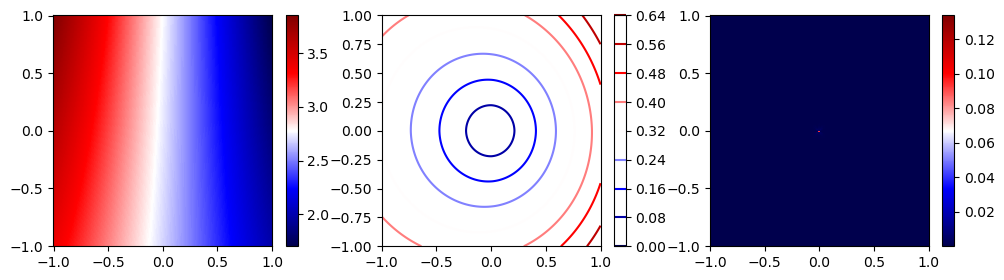

[3.025806579603689, 7.340530170929321, 3.3132430511497732, 3.3486419167353008]


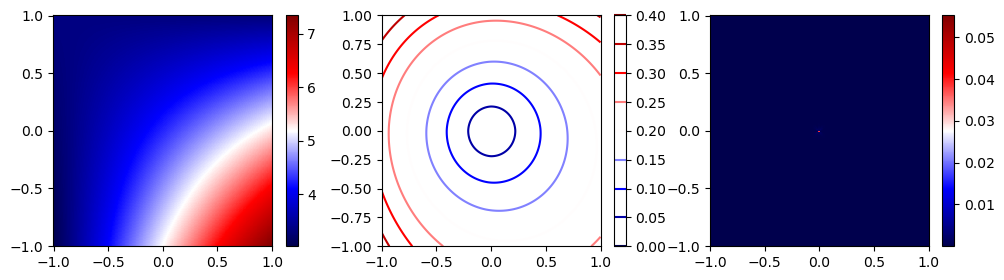

[1.9049617974911388, 0.36738928793269754, 7.5652384085765405, 2.0034396185265204]


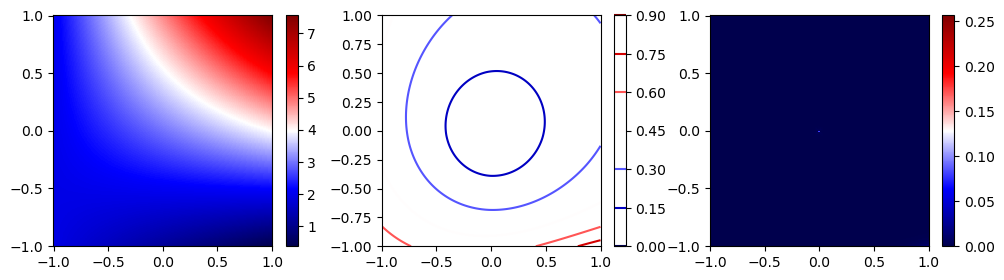

In [8]:
grid_1d = np.linspace(-1, 1, 501)
x, y  = np.meshgrid(grid_1d, grid_1d)

shapes = [
    lambda x, y: (1-x)*(1-y)/4,
    lambda x, y: (1+x)*(1-y)/4,
    lambda x, y: (1+x)*(1+y)/4,
    lambda x, y: (1-x)*(1+y)/4,
]
for i in range(3):
    corner_velocities = list(np.random.uniform(0.2, 8, (4,)))
    print(corner_velocities)
    v = sum([vi*ni(x, y) for vi, ni in zip(corner_velocities, shapes)])
    
    eik = EikonalSolver(vel=v)
    t = eik.grid 
    gt = eik.grad 
    res = abs(gt[0]**2 + gt[1]**2 - 1/v**2)

    fig, ax = plt.subplots(1,3,figsize=(12,3))
    plt.colorbar(
        ax[0].pcolor(x, y, v, cmap='seismic'), ax=ax[0]
    )
    plt.colorbar(
        ax[1].contour(x, y, t, cmap='seismic'), ax=ax[1]
    )
    plt.colorbar(
        ax[2].pcolor(x, y, res, cmap='seismic'), ax=ax[2]
    )
    plt.show()

In [9]:
from pyDOE import *

def lhs_uniform(d, n, bb = None):
    samples = lhs(d, n)
    if not bb:
        bb = [[0, 1] for i in range(d)]
    data = []
    for i, bb_i, in zip(range(d), bb):
        data.append(
            bb_i[0] + (bb_i[1]-bb_i[0]) * samples[:, i]
        )
    return data if len(data)>1 else data[0]

In [10]:
RECEIVER_SIZE = 20
SENSOR_SIZE = 100
SOURCE_RADI = 0.
VMIN = 0.2
VMAX = 8.0

In [11]:
from tensorflow.keras.utils import Sequence 


class DataGenerator(Sequence):
    def __init__(self, sample_size = 100, 
                       batch_size = dict(data=1000, domain=1000, bc=100),
                       sensor_size = 10,
                       recevier_size = 10,
                       source_radius = 0.1,
                       shuffle = True,
                       seed=1234):
        # generate data
        self._radius = source_radius
        self._sample_size = sample_size
        self._batch_size = batch_size
        self._sensor_size = sensor_size
        sensor_size_1d = int(np.sqrt(self._sensor_size) + 0.001)
        grid_1d_s = np.linspace(-1, 1, sensor_size_1d + 2)[1:-1]
        self._sensor = [gi.flatten() for gi in np.meshgrid(grid_1d_s, grid_1d_s)]
        self._recevier_size = recevier_size
        self._receiver = [np.linspace(-1, 1, recevier_size+2)[1:-1], 
                          np.ones(recevier_size)]
        self._shuffle = shuffle
        self._vmin = VMIN
        self._rmin = np.exp(np.log(VMIN/self._vmin) / 100)
        self._vmax = VMAX
        self._rmax = np.exp(np.log(VMAX/self._vmax) / 100)
        self._epoch = 1
        self._time = time.time()
        self._set_data()
        
    @property
    def batch_size(self):
        return self._batch_size

    def __len__(self):
        return self._sample_size

    def __getitem__(self, index):
        idx = self._sample_ids[index]
        return self.inputs[idx], self.targets[idx], self.sample_weights[idx]

    def on_epoch_end(self):
        if self._epoch % 100 == 0:
        #     self._vmin = max(VMIN, self._vmin*self._rmin)
        #     self._vmax = min(VMAX, self._vmax*self._rmax)
        #     self._set_data()
            print(f"{self._epoch} - {self._time - time.time()}s - re-sampling with vmin={self._vmin}, vmax={self._vmax}")
        if self._shuffle:
            np.random.shuffle(self._sample_ids)
        self._epoch += 1

    def _set_data(self):
        num_sample, batch_size = self._sample_size, self._batch_size
        inputs, targets, sample_weights = [], [], []
        for i in range(num_sample):
            x_source, y_source = list(np.random.uniform(-0.9, 0.9, 2))
            corner_velocities = list(np.random.uniform(self._vmin, self._vmax, (4,)))
            inputs_i, targets_i, sample_weights_i = self.__generate_batch_data(x_source, y_source, corner_velocities, batch_size)
            inputs.append(inputs_i)
            targets.append(targets_i)
            sample_weights.append(sample_weights_i)
        # concat data
        self.inputs = inputs
        self.targets = targets
        self.sample_weights = sample_weights
        self._sample_ids = np.arange(num_sample)

    def __generate_batch_data(self, x_source, y_source, corner_velocities, batch_size):
        counter = 0
        
        # eikonal (travel-time) solution
        grid_1d = np.linspace(-1, 1, 101)
        x_grid, y_grid = np.meshgrid(grid_1d, grid_1d)
        v_grid = self.interpolate_corner_velocities(corner_velocities, x_grid, y_grid)
        eik2d = EikonalSolver(vel=v_grid, source=[x_source, y_source])
        
        # sample data
        ids_data = np.random.choice(x_grid.size, batch_size['data'], replace=False)
        x_data, y_data = x_grid.flatten()[ids_data], y_grid.flatten()[ids_data]
        target_data = eik2d.grid.flatten()[ids_data]
        ids_data = np.arange(batch_size['data']) + counter
        counter += ids_data.size

        size_sample = counter
        
        # trunk inputs
        x_trunk = np.hstack([x_data]).reshape(-1,1)
        y_trunk = np.hstack([y_data]).reshape(-1,1)
        
        # - BRANCH -
        # velocity-branch inputs
        x_sensor, y_sensor = self._sensor
        v_sensor = self.interpolate_corner_velocities(corner_velocities, x_sensor, y_sensor)
        v_branch = np.tile(v_sensor, (size_sample, 1))
        
        # recevier-branch inputs
        x_receiver, y_receiver = self._receiver
        t_receiver = eik2d(x_receiver, y_receiver)
        t_branch = np.tile(t_receiver, (size_sample, 1))

        # inputs
        inputs = [x_trunk, y_trunk, v_branch, t_branch]
        targets, sample_weights = [], []
        for idx, tg in zip([ids_data],
                           [target_data]):
            wi = np.zeros(size_sample)
            wi[idx] = size_sample / idx.size
            sample_weights.append(wi)
            ti = np.zeros((size_sample, ))
            if isinstance(tg, np.ndarray):
                ti[idx] = tg
            targets.append(ti.reshape(-1,1))
        
        return inputs, targets, sample_weights
    
    
    def generate_test_data(self, Xs, Ys, Vs, Nx=100, Ny=100, sensor_size=10, noise=0.0):
        counter = 0
        radi = self._radius
        
        # eikonal solution
        x_grid, y_grid = np.meshgrid(np.linspace(-1,1,Nx), np.linspace(-1,1,Ny))
        v_grid = self.interpolate_corner_velocities(Vs, x_grid, y_grid)
        eik2d = EikonalSolver(vel=v_grid, source=[Xs, Ys])
        t_grid = eik2d.grid
        
        # sample domain
        x_trunk, y_trunk = x_grid.reshape(-1,1), y_grid.reshape(-1,1)
        v_trunk = v_grid.reshape(-1,1)
        target = t_grid.reshape(-1,1)
        size_sample = Nx*Ny
        
        # velocity-branch inputs
        x_sensor, y_sensor = self._sensor
        v_sensor = self.interpolate_corner_velocities(Vs, x_sensor, y_sensor)
        v_branch = np.tile(v_sensor, (size_sample, 1))
        
        # recevier-branch inputs
        x_receiver, y_receiver = self._receiver
        t_receiver = eik2d(x_receiver, y_receiver)
        if noise > 0:
            t_receiver += noise*np.std(t_receiver)*np.random.normal(0, 1, t_receiver.shape)
            t_receiver = np.maximum(0., t_receiver)
        
        t_branch = np.tile(t_receiver, (size_sample, 1))

        # inputs
        inputs = [x_trunk, y_trunk, v_branch, t_branch]
        
        return inputs, v_trunk, target
    
    def interpolate_corner_velocities(self, vs, x, y):
        shapes = [lambda x, y: (1-x)*(1-y)/4, # bottom-left
                  lambda x, y: (1+x)*(1-y)/4, # bottom-right
                  lambda x, y: (1-x)*(1+y)/4, # top-left
                  lambda x, y: (1+x)*(1+y)/4] # top-right
        return sum([vi*si(x, y) for vi, si in zip(vs, shapes)])


In [12]:
sn.reset_session()
sn.set_random_seed(1234)

In [13]:
# Define the model
class PI_DeepONet:
    def __init__(self, sensor_size=20, 
                       receiver_size=20,
                       embedding_size=20,
                       trunk_layers=7*[20],
                       sensor_branch_layers=7*[20],
                       receiver_branch_layers=7*[20], 
                       actf='tanh'):
        
        # velocity (sensor) branch net
        self.branch_inputs = [sn.Variable('vb', units=sensor_size)]
        self.branch_embedding = sn.Field('branch', units=embedding_size)
        self.branch = sn.Functional(self.branch_embedding, self.branch_inputs, sensor_branch_layers, actf, actf)
        
        # receiver branch net
        self.r_branch_inputs = [sn.Variable('rb', units=receiver_size)]
        self.r_branch_embedding = sn.Field('r_branch', units=embedding_size)
        self.r_branch = sn.Functional(self.r_branch_embedding, self.r_branch_inputs, receiver_branch_layers, actf, actf)
        
        
        # Network initialization and evaluation functions
        self.trunk_inputs = [sn.Variable('xt'), sn.Variable('yt')]
        
        self.trunk_embedding = sn.Field('trunk-0', units=embedding_size)
        self.trunk = sn.Functional(self.trunk_embedding, self.trunk_inputs, output_activation=actf)
        
        for i in range(4):
            hidden_inputs = [self.trunk * self.branch, 
                             self.trunk + self.branch, 
                             self.trunk * self.r_branch,
                             self.trunk + self.r_branch]
            self.trunk_embedding = sn.Field('trunk-{}'.format(i+1), units=embedding_size)
            self.trunk = sn.Functional(self.trunk_embedding, hidden_inputs, output_activation=actf)
        
        
        hidden_inputs = [self.trunk * self.branch, 
                         self.trunk + self.branch, 
                         self.trunk * self.r_branch,
                         self.trunk + self.r_branch]
        
        self.output = sn.Functional('u', hidden_inputs)
        
        du_dx = sn.diff(self.output, self.trunk_inputs[0])
        du_dy = sn.diff(self.output, self.trunk_inputs[1])
        eikonal = sn.rename(du_dx**2 + du_dy**2, 'eikonal')
        data = sn.rename(self.output*1.0, 'data')
        
        #lipschitz reg
        du_dvbranch = sn.diff(self.output, self.branch_inputs[0])
        du_dtbranch = sn.diff(self.output, self.r_branch_inputs[0])
        
        self.losses = [data] #, du_dvbranch, du_dtbranch]
        
        self.model = sn.SciModel(self.trunk_inputs + self.branch_inputs + self.r_branch_inputs,
                                 self.losses,
                                 optimizer='adam')
        
        self.model_bfgs = sn.SciModel(self.trunk_inputs + self.branch_inputs + self.r_branch_inputs,
                                      self.losses,
                                      optimizer='scipy-l-bfgs-b')
    
        
    def eval(self, inputs):
        return self.model(inputs)

    def eval_u(self, inputs):
        return self.output.eval(self.model, inputs)
    
    def train(self, data_generator, epochs=200, verbose=1):
        batch_size = data_generator.batch_size
        learning_rate = dict(scheduler="exponential_decay", 
                             initial_learning_rate=4e-4,
                             final_learning_rate=1e-5,
                             delay_epochs=1000,
                             decay_epochs=10000)
        learning_rate = ([0,       500, 1500, 2000,    3000,   5000, 10000], 
                         [0.5e-4, 1e-4, 1e-4, 2e-4, 0.75e-4, 0.5e-4,  1e-5])
        self.history = self.model.train(
            data_generator,
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=verbose, 
            learning_rate=learning_rate,
            reduce_lr_after=100,
            # target_weights=[1., 0.01, 0.01]
            save_weights={"path": "EnDeepONet_SmoothVelocity/weights", "freq": 100}
        )
        return self.history
    
    def train_lbfgs(self, data_generator, epochs=200, verbose=1):
        batch_size = data_generator.batch_size
        self.history_bfgs = self.model_bfgs.train(
            data_generator,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose,
            learning_rate=0.001
        )
        return self.history_bfgs
    
    def plot_loss(self):
        loss = self.history.history["loss"]
        plt.semilogy(np.array(loss) / loss[0], label="total_loss")
        plt.legend()
        plt.show()

In [14]:
dg = DataGenerator(
    sample_size=200,
    batch_size={'data': 2000, 'domain': 1000, 'bc':50},
    sensor_size=SENSOR_SIZE,
    recevier_size=RECEIVER_SIZE,
    source_radius=SOURCE_RADI
)

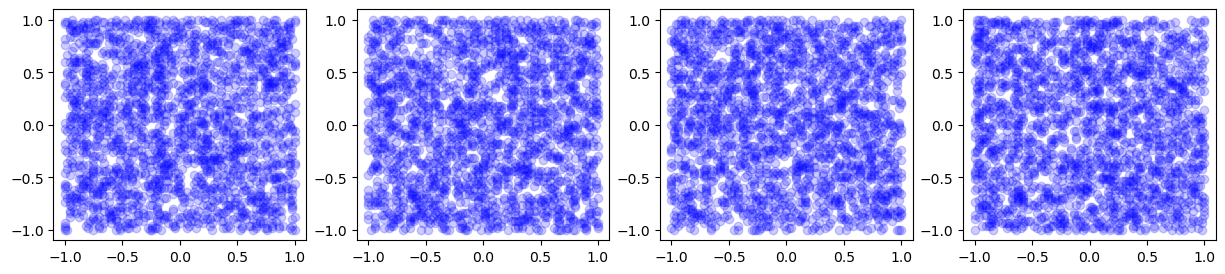

In [15]:
from itertools import cycle

n_plot = 4
fig, ax = plt.subplots(1, n_plot, figsize=(15, 3))
for i in range(n_plot):
    cycol = cycle('brycmg')
    inputs, targets, weights = dg[np.random.choice(len(dg))]
    for wi in weights:
        x_trunk, y_trunk, v_branch, t_branch = inputs
        idx = wi > 0
        ax[i].scatter(x_trunk[idx], y_trunk[idx], color=next(cycol), alpha=0.2)

plt.show()

In [16]:
DON = PI_DeepONet(
    sensor_size=SENSOR_SIZE,
    receiver_size=RECEIVER_SIZE,
    embedding_size=100,
    sensor_branch_layers=[100, 100],
    receiver_branch_layers=[100, 100],
    trunk_layers=[20, 50, 100, 100],
    actf='tanh'
)

In [17]:
list_weights = os.listdir(PATH_NAME)
list_weights = list(sorted(filter(lambda x: x.startswith('weights-') and not x.startswith('weights-start'), list_weights)))
list_weights[-10:]

['weights-09930-1.193e-06.hdf5',
 'weights-09940-1.188e-06.hdf5',
 'weights-09950-1.517e-06.hdf5',
 'weights-09960-1.262e-06.hdf5',
 'weights-09970-1.444e-06.hdf5',
 'weights-09980-1.486e-06.hdf5',
 'weights-09990-2.045e-06.hdf5',
 'weights-10000-1.580e-06.hdf5',
 'weights-end.hdf5',
 'weights-lbfgs.hdf5']

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/weights-00010-2.671e-02.hdf5


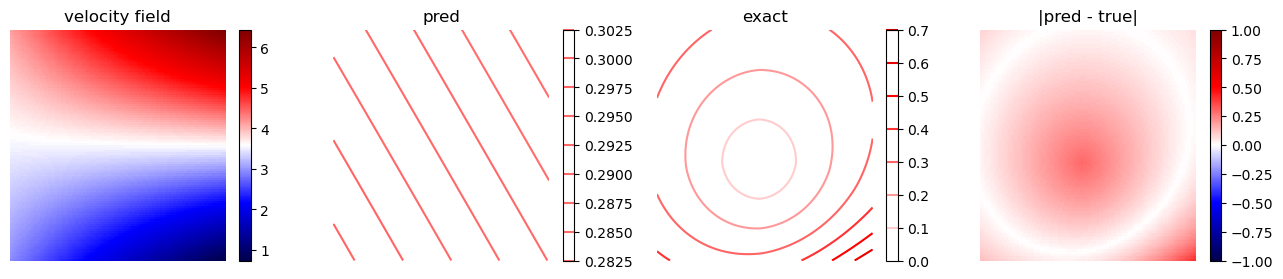

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/weights-01010-1.561e-04.hdf5


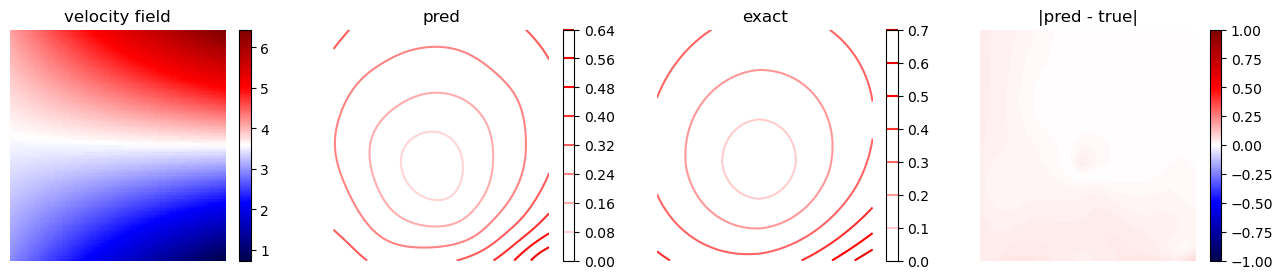

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/weights-02010-3.170e-04.hdf5


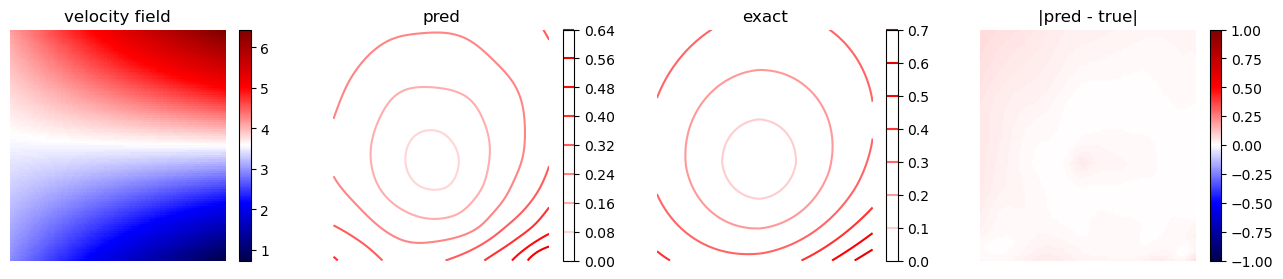

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/weights-03010-4.548e-05.hdf5


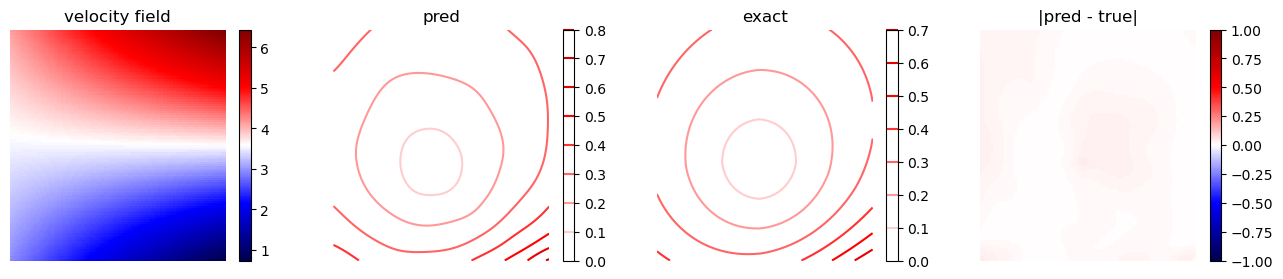

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/weights-04010-2.506e-05.hdf5


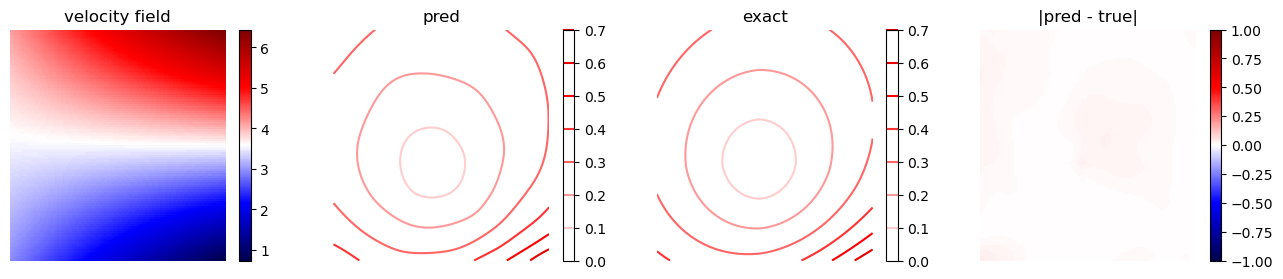

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/weights-05010-1.095e-05.hdf5


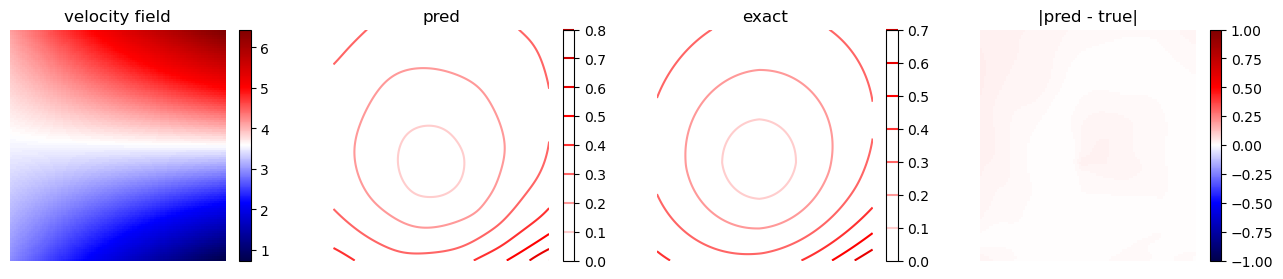

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/weights-06010-1.779e-05.hdf5


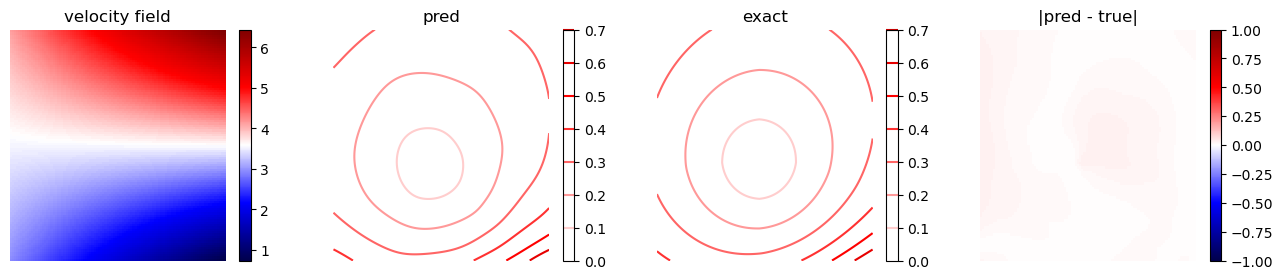

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/weights-07010-9.913e-06.hdf5


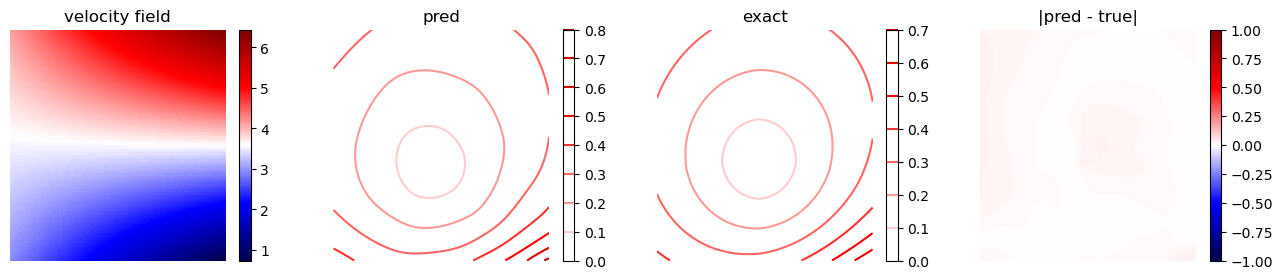

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/weights-08010-4.826e-06.hdf5


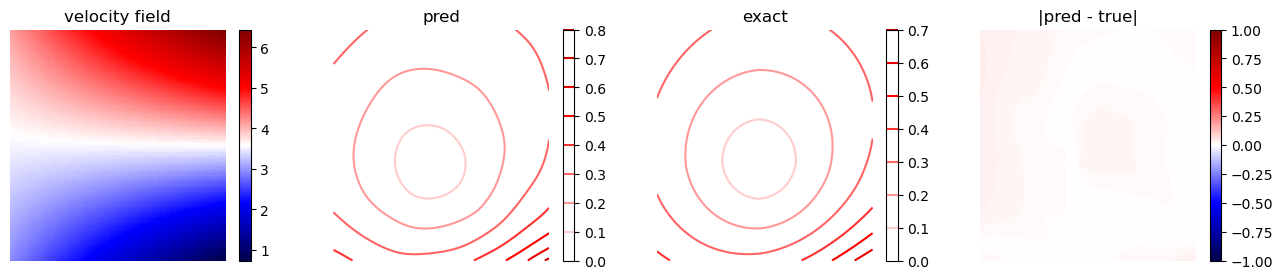

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/weights-09010-3.069e-06.hdf5


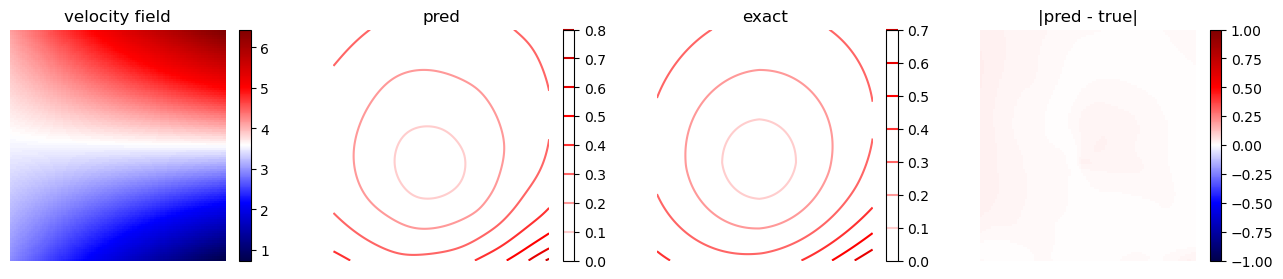

loading ...  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/weights-end.hdf5


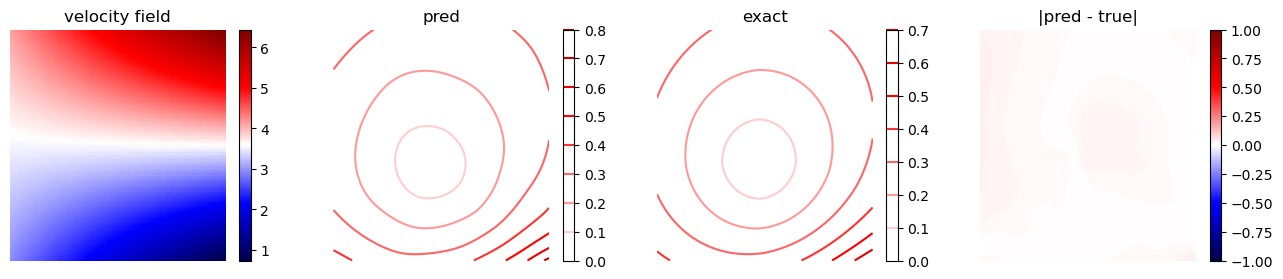

In [18]:
Nx, Ny = 100, 100
v_corners = list(np.random.uniform(VMIN, VMAX, (4,)))
x_source, y_source = list(np.random.uniform(-0.9, 0.9, (2,)))
test_data, vel_data, target_data = dg.generate_test_data(x_source, y_source, v_corners, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)
x_test = test_data[0].reshape(Nx, Ny)
y_test = test_data[1].reshape(Nx, Ny)
v_test = vel_data.reshape(Nx, Ny)
exact = target_data.reshape(Nx, Ny)
    

for weight in list_weights[::int(len(list_weights)/10)]:
    weight_path = os.path.join(PATH_NAME, weight)
    print('loading ... ', weight_path)
    DON.model.load_weights(weight_path)
    
    pred = DON.eval_u(test_data).reshape(Nx, Ny)

    fig, ax = plt.subplots(1, 4, figsize=(16, 3))
    
    ax0 = ax[0].pcolor(x_test, y_test, v_test, cmap='seismic')
    ax[0].set_title('velocity field')
    ax[0].axis('off')
    plt.colorbar(ax0, ax=ax[0])
    
    ax1 = ax[1].contour(x_test, y_test, pred, cmap='seismic', vmin=-1, vmax=1)
    ax[1].set_title('pred')
    ax[1].axis('off')
    plt.colorbar(ax1, ax=ax[1])
    
    ax2 = ax[2].contour(x_test, y_test, exact, cmap='seismic', vmin=-1, vmax=1)
    ax[2].set_title('exact')
    ax[2].axis('off')
    plt.colorbar(ax2, ax=ax[2])
    
    ax3 = ax[3].pcolor(x_test, y_test, abs(pred - exact), cmap='seismic', vmin=-1, vmax=1)
    ax[3].set_title('|pred - true|')
    ax[3].axis('off')
    plt.colorbar(ax3, ax=ax[3])
    
    plt.show()
    

In [19]:
if 'weights-end.hdf5' in list_weights:
    weight_path = os.path.join(PATH_NAME, 'weights-end.hdf5')
else:
    weight_path = os.path.join(PATH_NAME, list_weights[-2])
DON.model.load_weights(weight_path)

In [20]:
def cust_pcolor(AX, X, Y, P, Xs=None, Ys=None, title=None, cmap='jet', xlabel=True, ylabel=False, vmin=None, vmax=None):
    ax1 = AX.pcolor(X, Y, P, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(ax1, ax=AX)
    if Xs != None and Ys!=None:
        AX.scatter(Xs, Ys, marker='*', color='r')
    AX.set_title(title)
    AX.set_xticks(np.linspace(-1, 1, 5), np.linspace(0., 2., 5))
    AX.set_yticks(np.linspace(-1, 1, 5), np.linspace(2., 0., 5))
    if xlabel: AX.set_xlabel('Offset (km)')
    if ylabel: AX.set_ylabel('Depth (km)')

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-pub.png


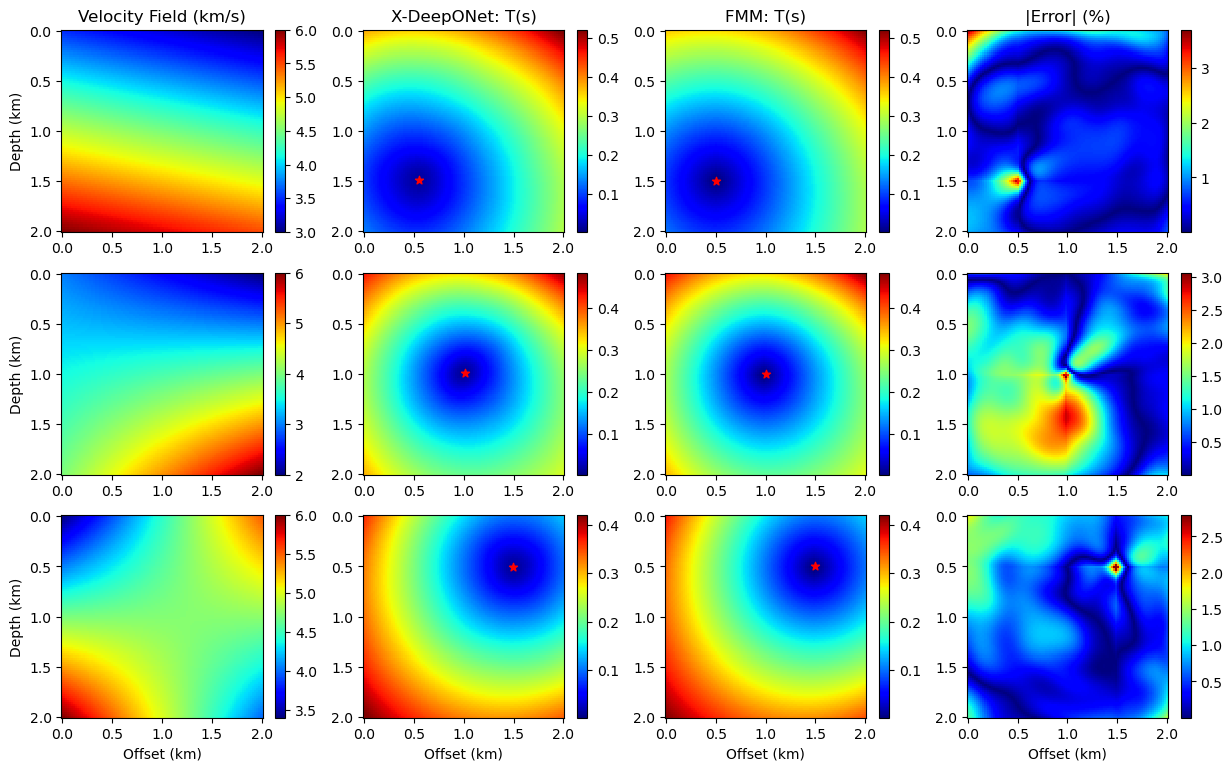

In [21]:
Nx, Ny = 100, 100

rmse_error = []
source_locs = []
source_error = []

x_sources = np.array([-0.5, 0., 0.5])
y_sources = np.array([-0.5, 0., 0.5])

fig, ax = plt.subplots(3, 4, figsize=(13, 8))

np.random.seed(3435)
v_list = [
    (6, 5.5, 3.5, 3),
    (4, 6, 3, 2),
    (6, 4, 3.4, 5.5)
]
    
for i in range(x_sources.size):     
    # v_corners = list(np.random.uniform(VMIN, VMAX, (4,)))
    v_corners = v_list[i]
    #x_source, y_source = list(np.random.uniform(-0.8, 0.8, (2,)))
    x_source = x_sources[i]
    y_source = y_sources[i]
    
    test_data, vel_data, target_data = dg.generate_test_data(
        x_source, y_source, v_corners, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)

    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    v_test = vel_data.reshape(Nx, Ny)
    exact = target_data.reshape(Nx, Ny)
        
    pred = DON.eval_u(test_data).reshape(Nx, Ny)
    
    error = abs(pred - exact) / exact.max() * 100
    
    i_source, j_source = np.unravel_index(pred.argmin(), pred.shape)
    x_source_pred = x_test[i_source, j_source]
    y_source_pred = y_test[i_source, j_source]

    cust_pcolor(ax[i, 0], x_test, y_test, v_test, title='Velocity Field (km/s)' if i==0 else None, 
                cmap='jet', ylabel=True, xlabel=True if i==2 else False)
    cust_pcolor(ax[i, 1], x_test, y_test, pred, x_source_pred, y_source_pred, title='X-DeepONet: T(s)' if i==0 else None, 
                cmap='jet', vmin=exact.min(), vmax=exact.max(), xlabel=True if i==2 else False)
    cust_pcolor(ax[i, 2], x_test, y_test, exact, y_source, x_source, title='FMM: T(s)' if i==0 else None,
                cmap='jet', xlabel=True if i==2 else False)
    cust_pcolor(ax[i, 3], x_test, y_test, error, title='|Error| (%)' if i==0 else None,
                cmap='jet', xlabel=True if i==2 else False)

plt.subplots_adjust(0.08, 0.08, 0.97, 0.94, 0.2, 0.2)
print('Saving to: ', os.path.join(PATH_NAME, 'vel-pred-pub.png'))
plt.savefig(os.path.join(PATH_NAME, 'vel-pred-pub.png'))
plt.show()
#break

# raise ValueError

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-0.png


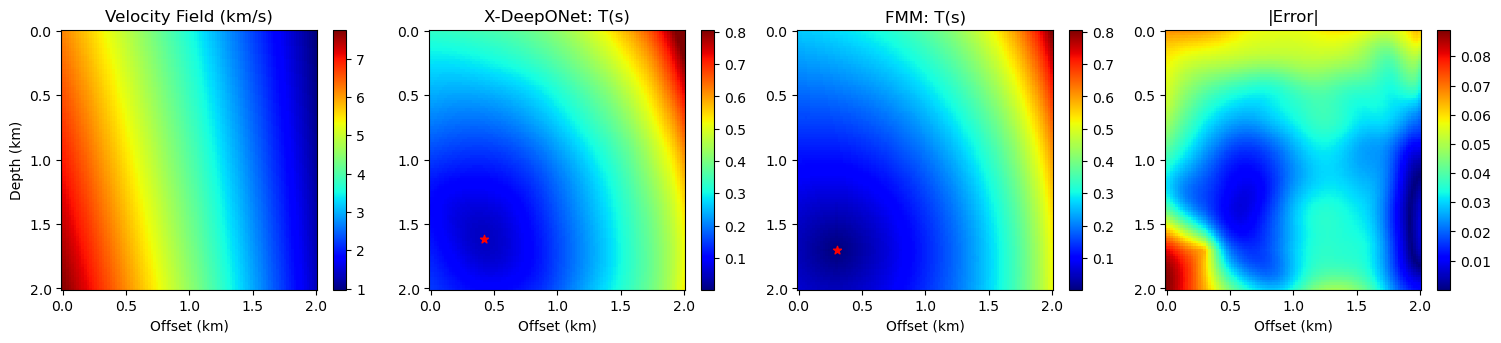

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-1.png


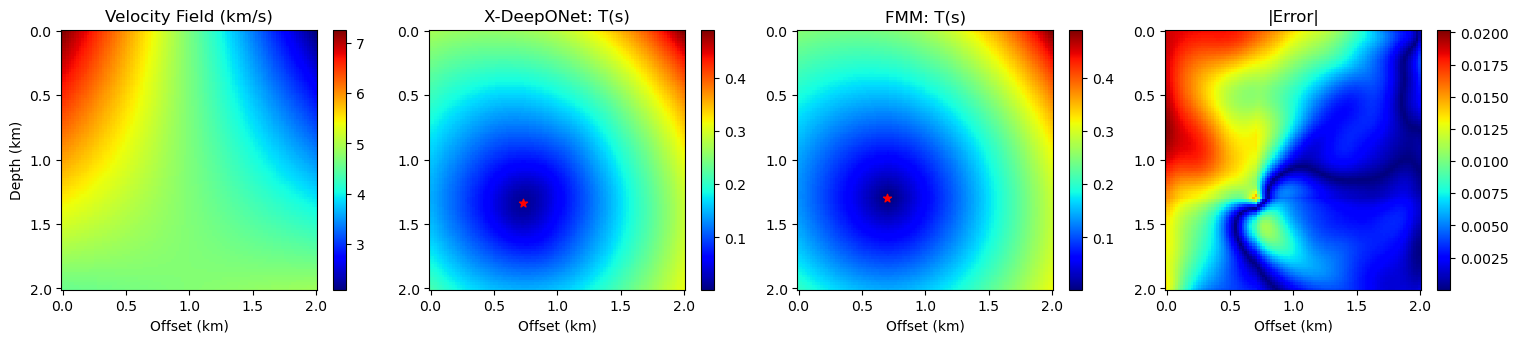

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-2.png


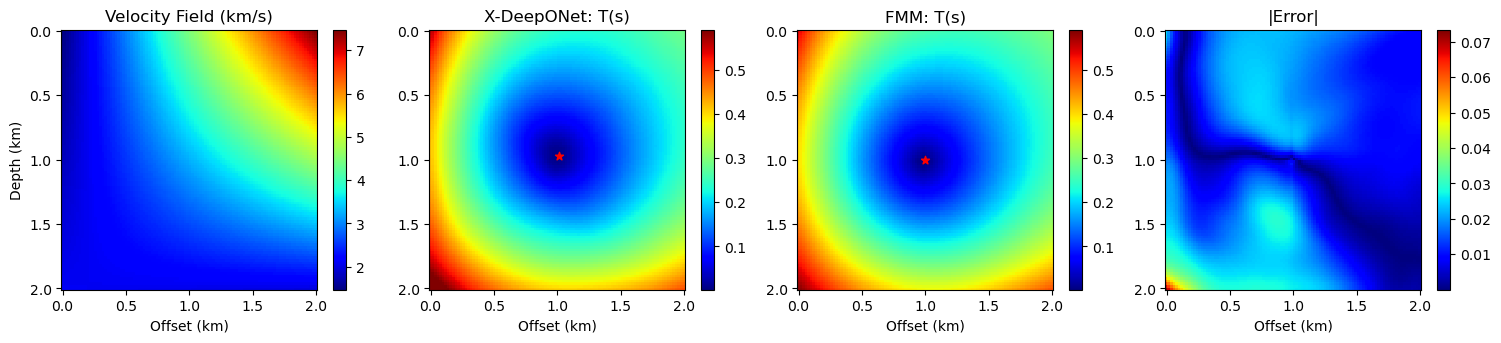

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-3.png


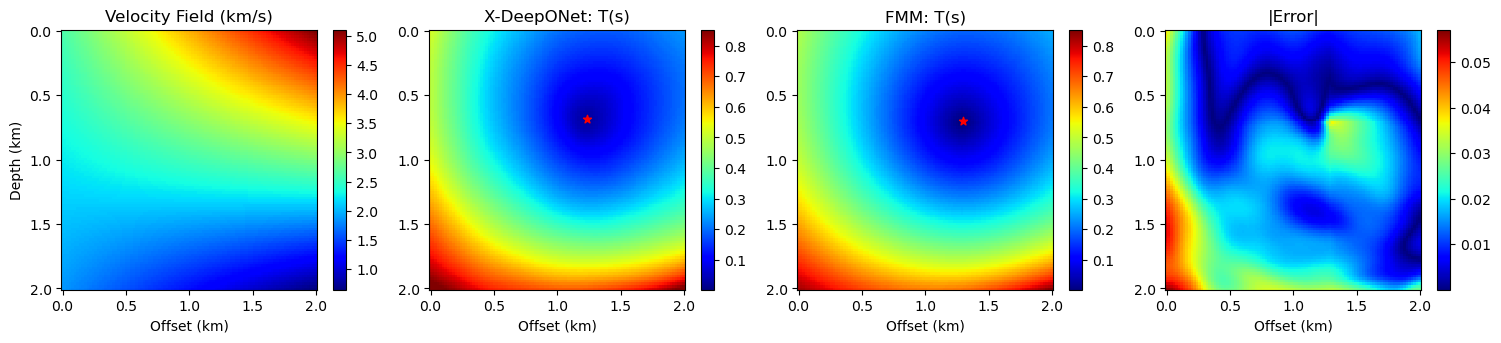

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-4.png


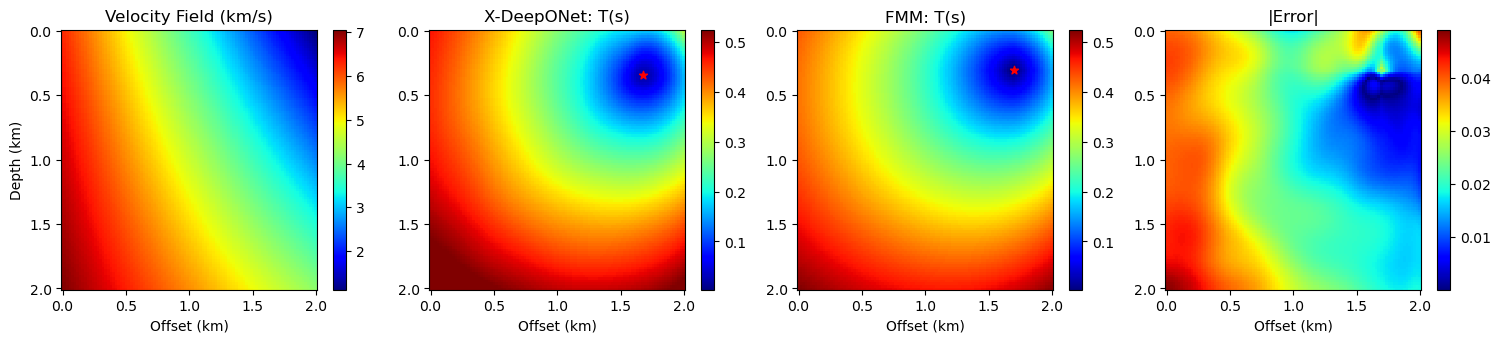

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-5.png


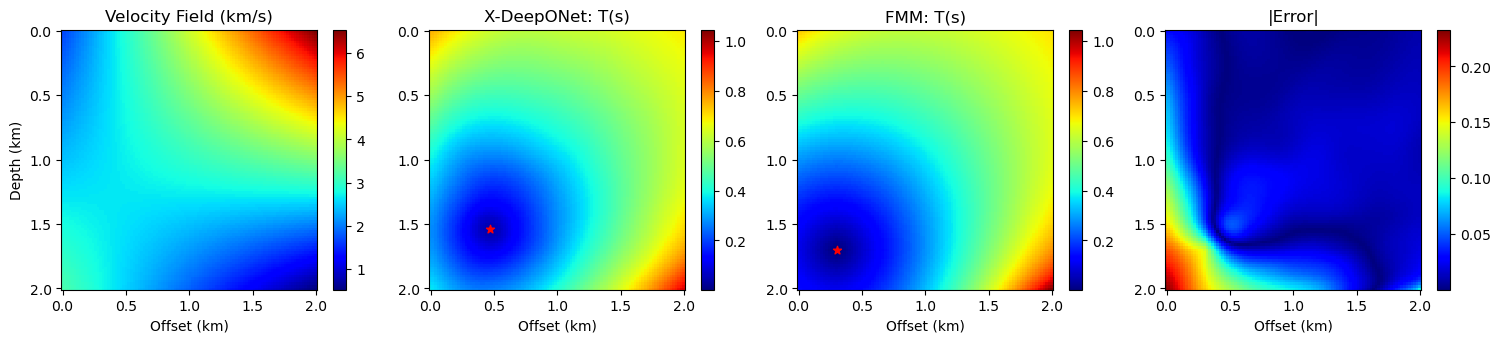

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-6.png


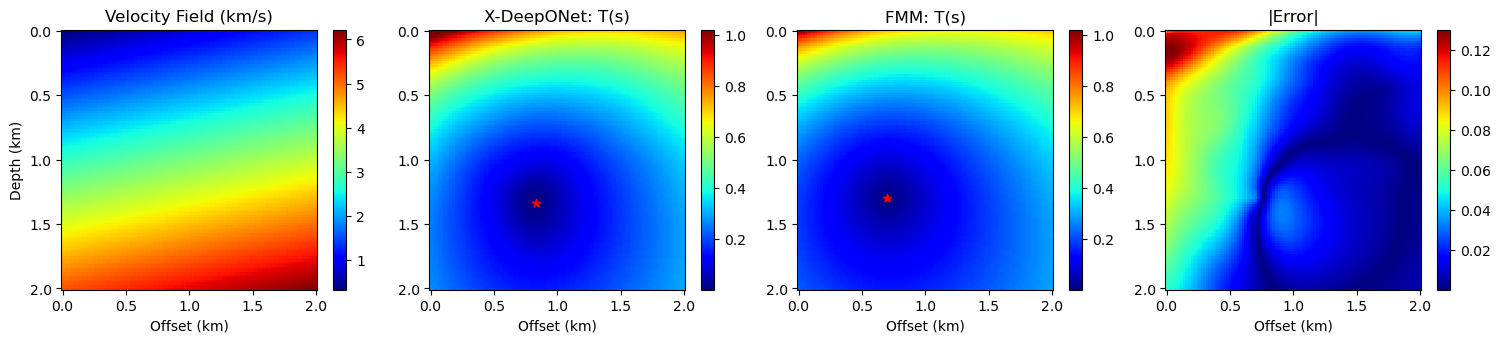

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-7.png


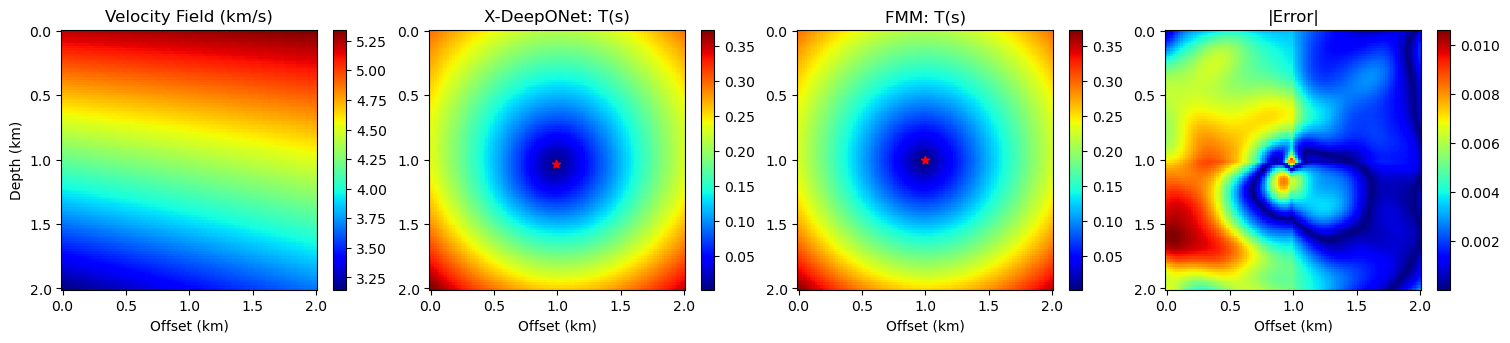

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-8.png


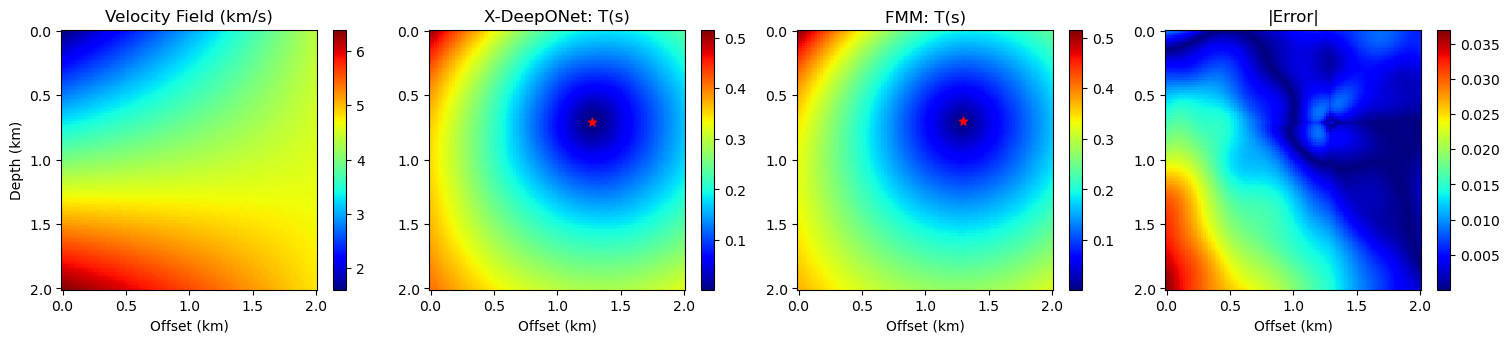

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-9.png


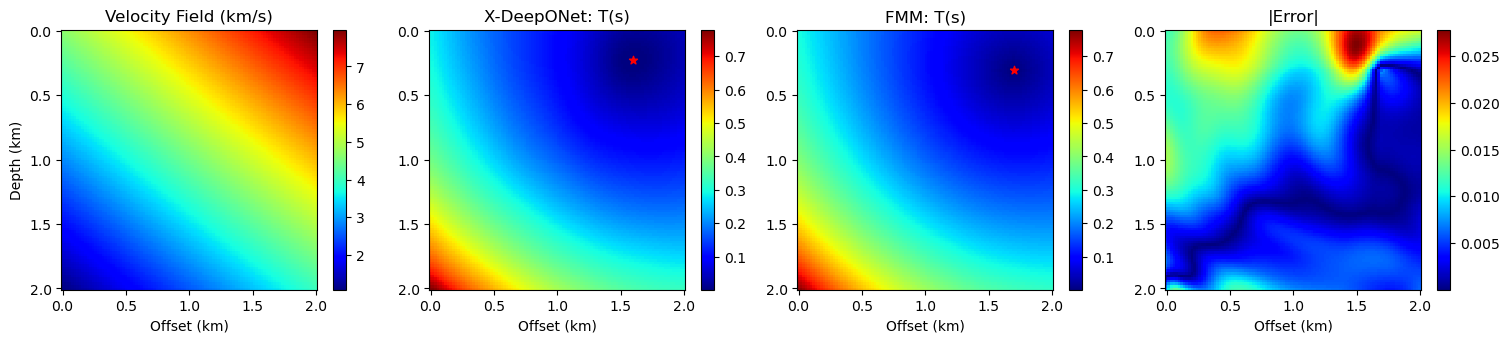

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-10.png


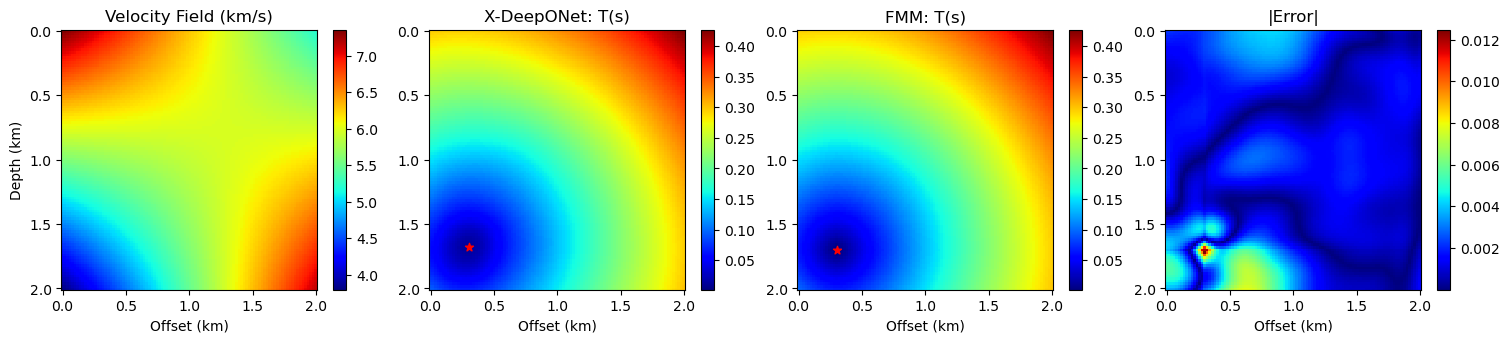

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-11.png


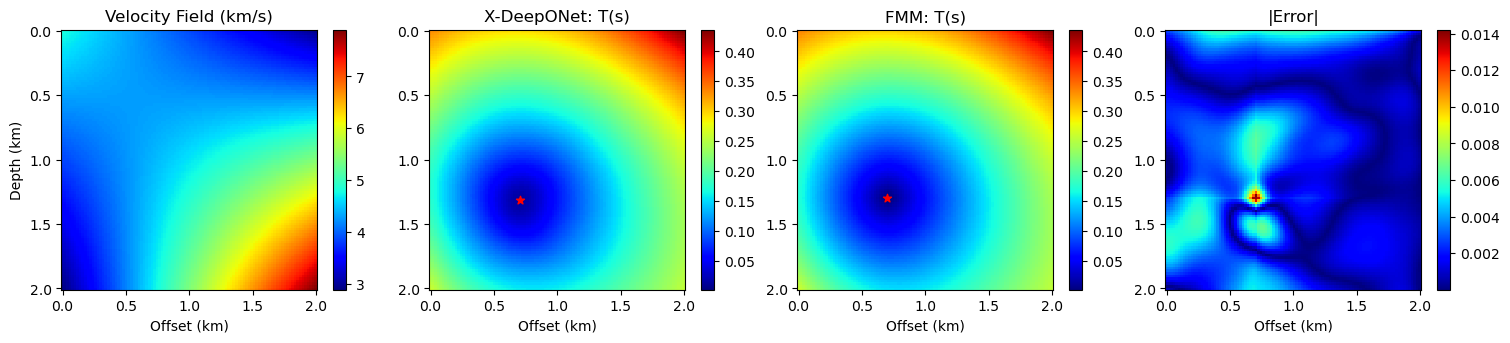

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-12.png


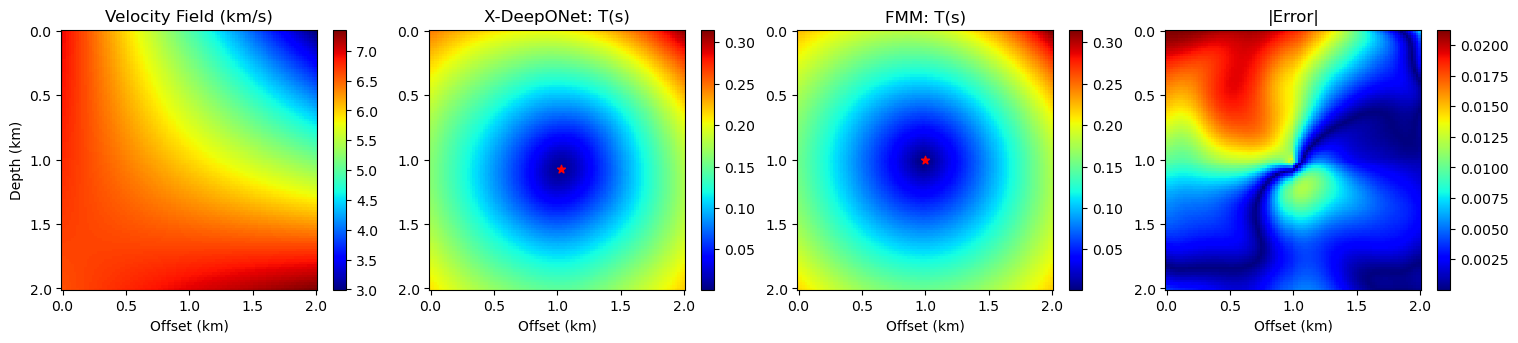

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-13.png


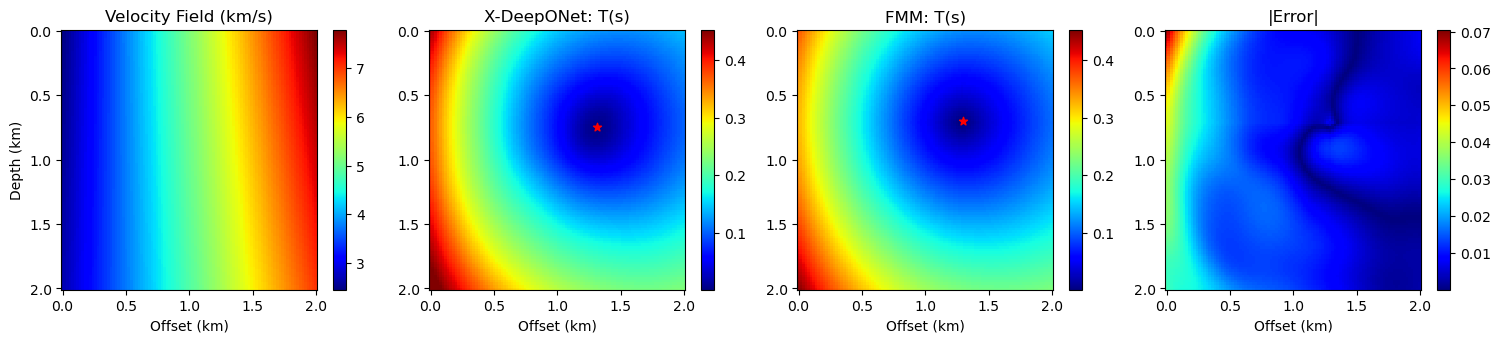

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-14.png


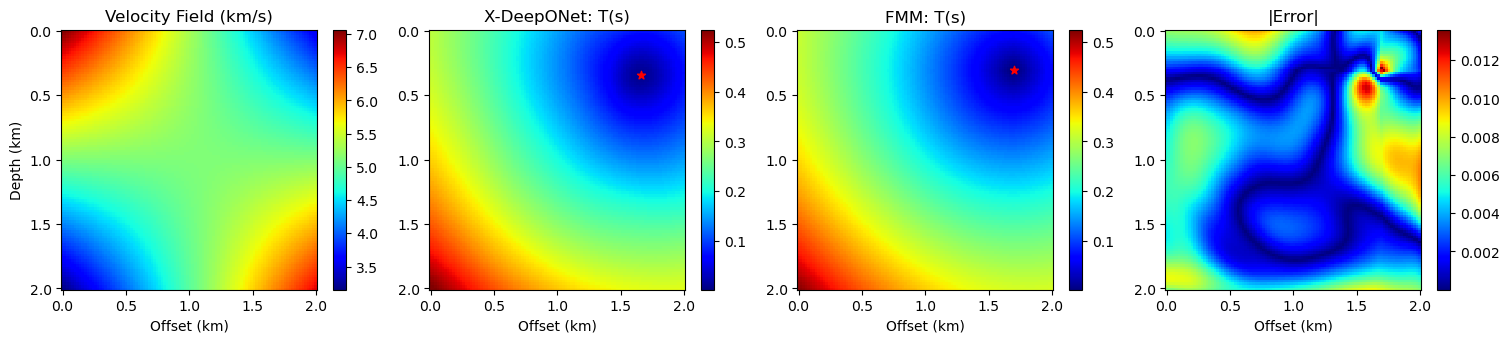

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-15.png


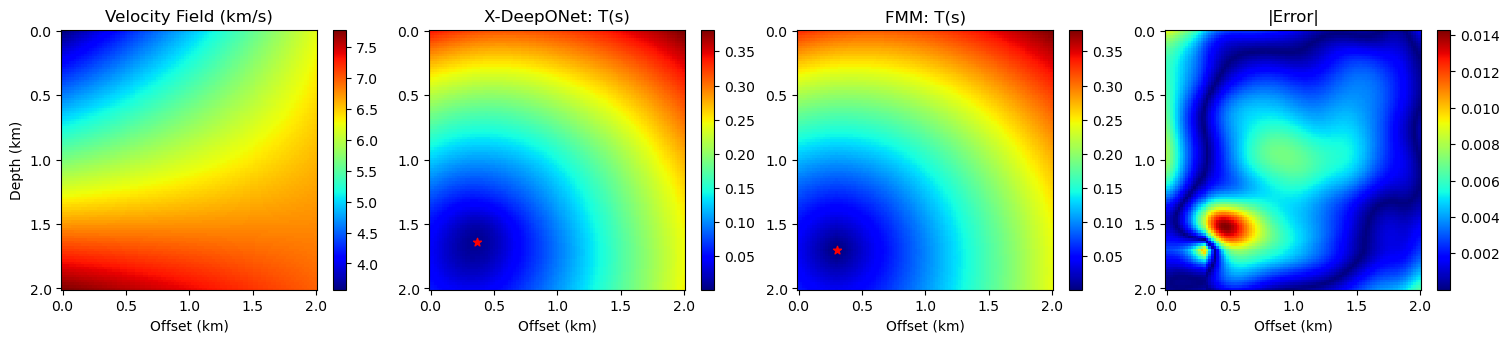

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-16.png


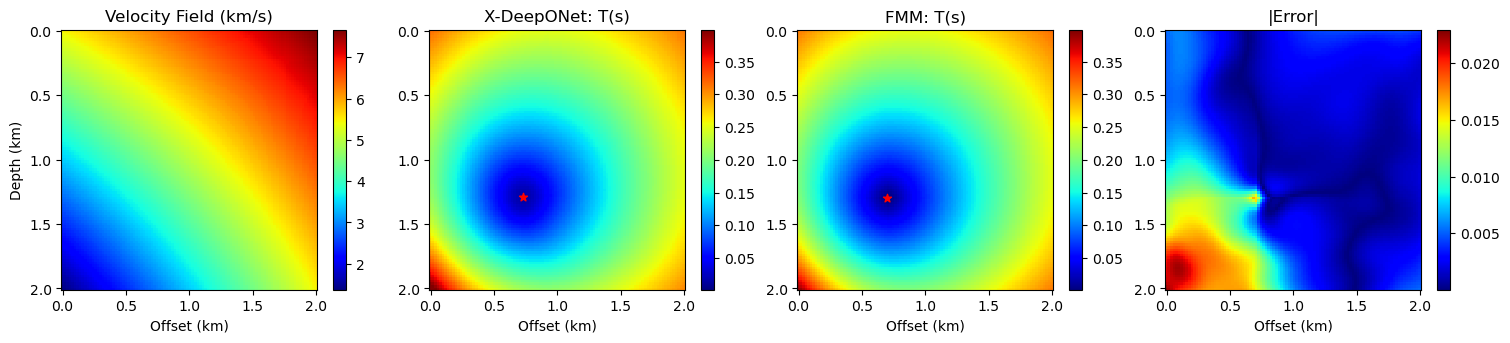

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-17.png


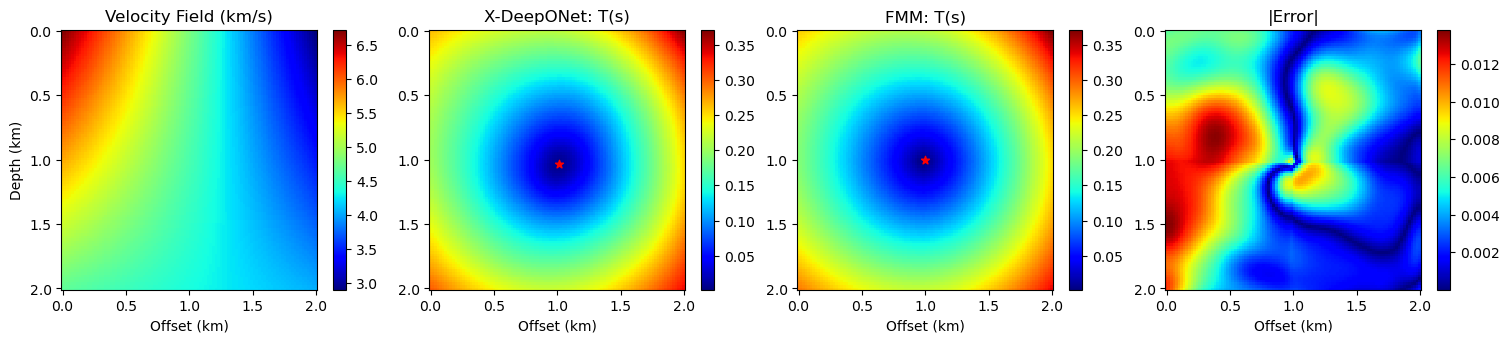

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-18.png


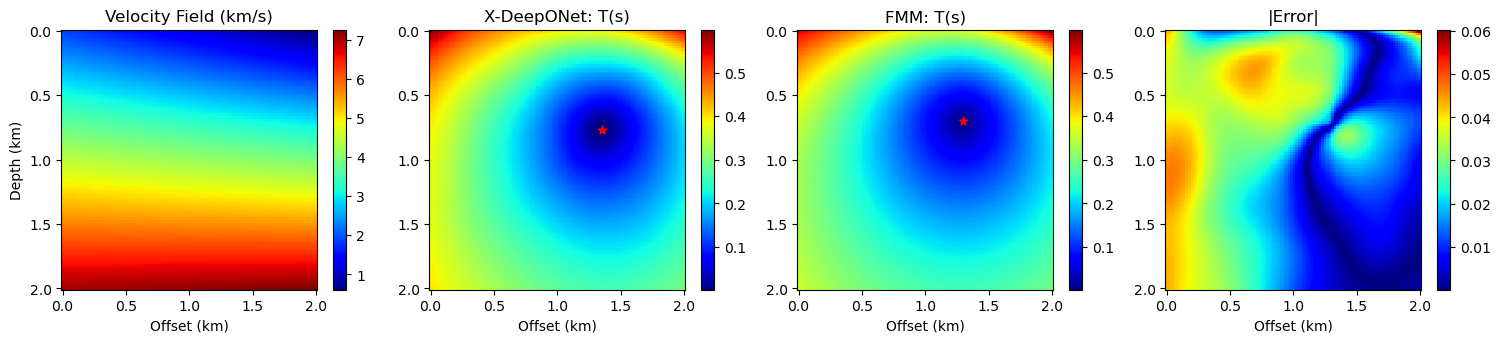

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-19.png


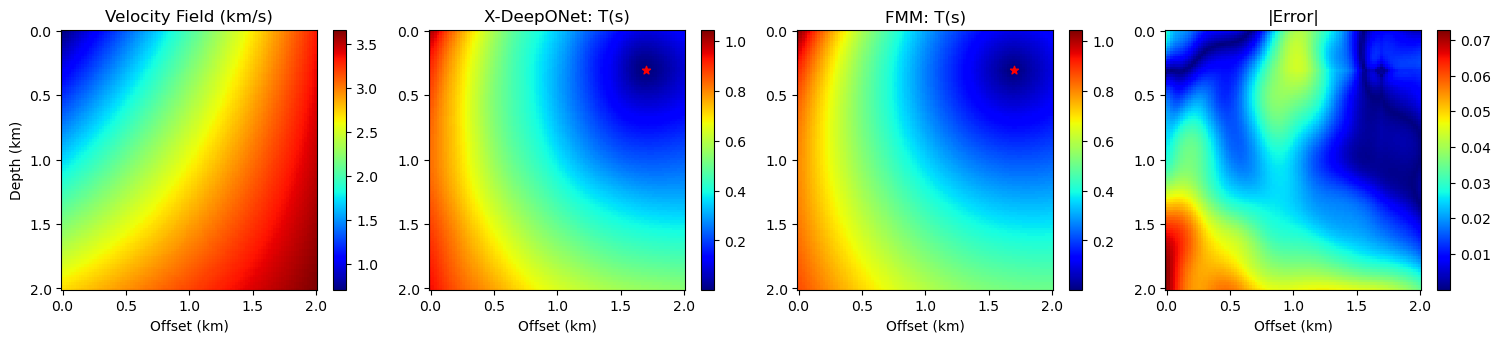

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-20.png


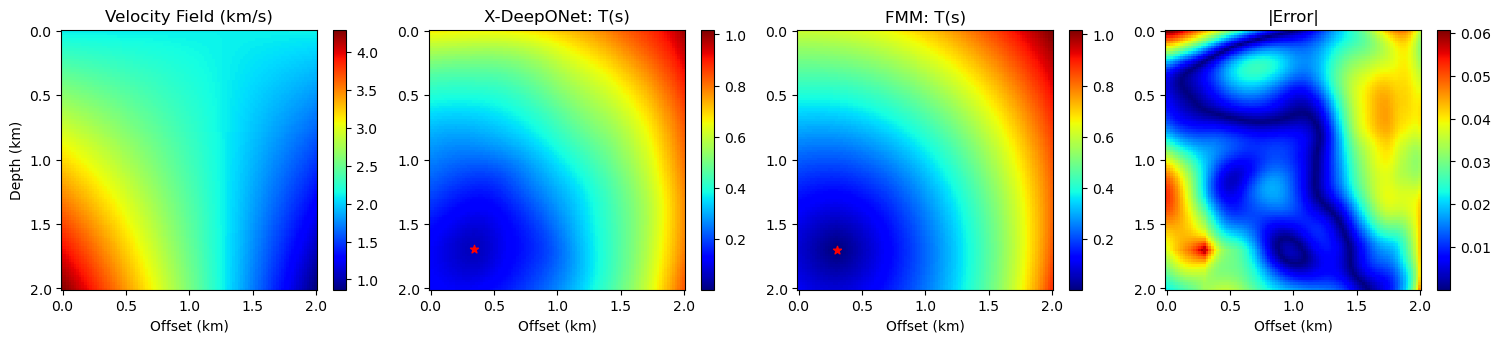

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-21.png


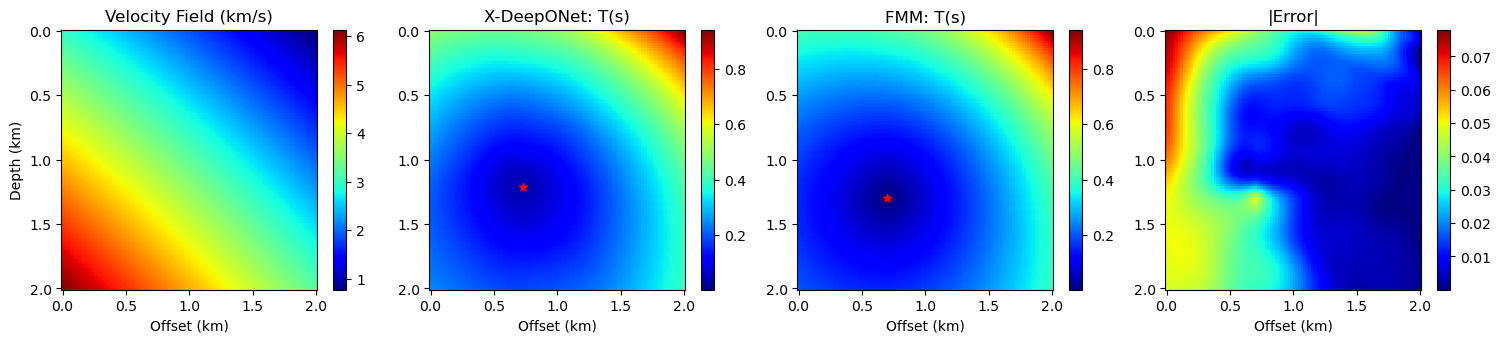

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-22.png


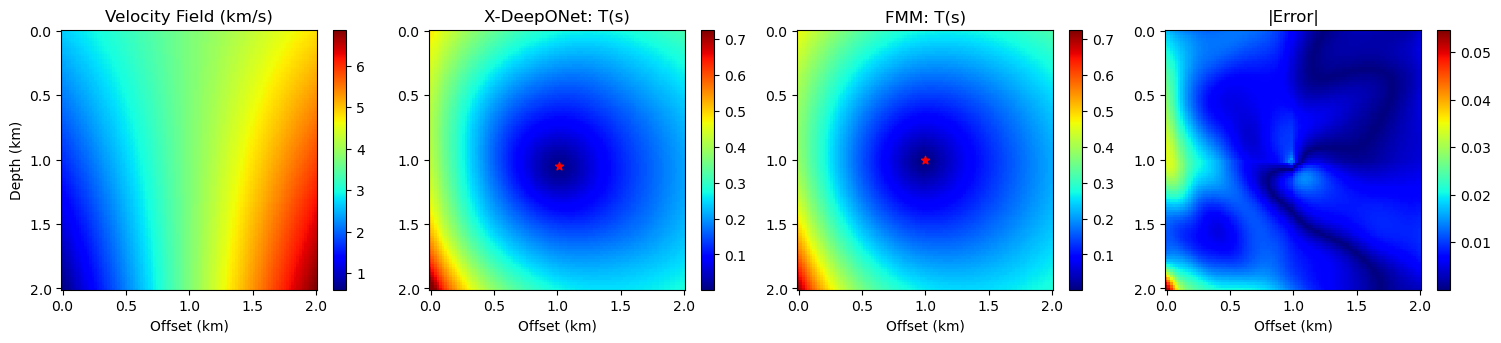

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-23.png


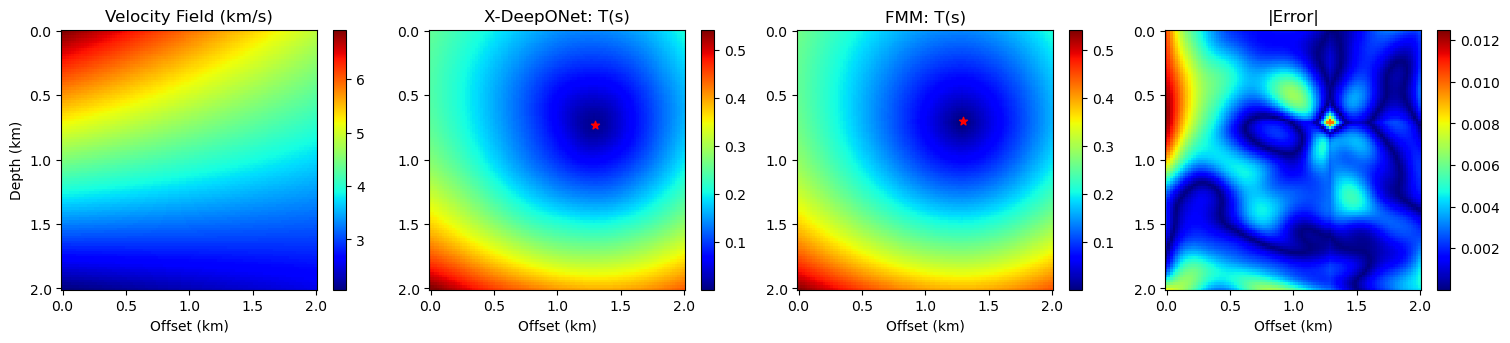

Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/vel-pred-24.png


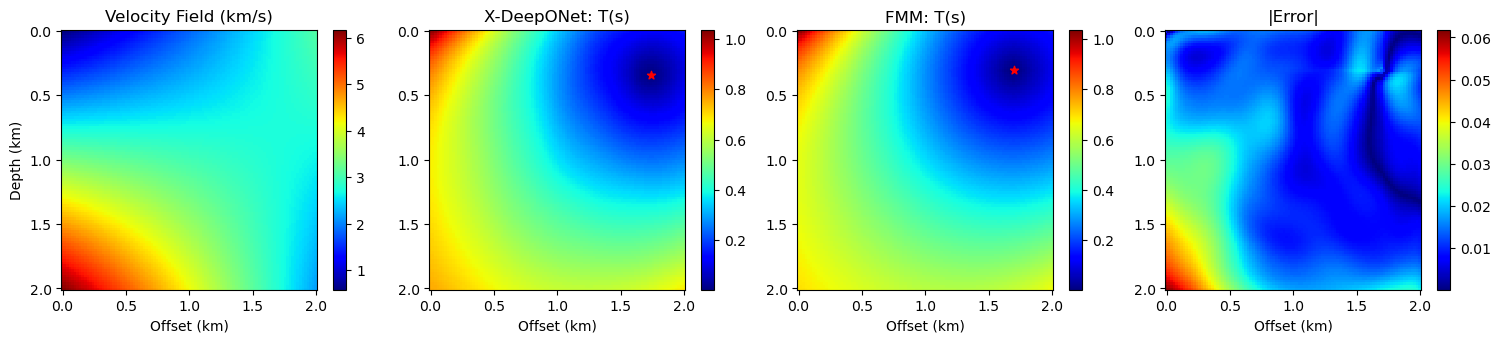

In [22]:
Nx, Ny = 100, 100

rmse_error = []
source_locs = []
source_error = []

x_sources, y_sources = np.meshgrid(
    [-0.7, -0.3, 0., 0.3, 0.7],
    [-0.7, -0.3, 0., 0.3, 0.7],
)

np.random.seed(12324)

for i in range(x_sources.size):     
    v_corners = list(np.random.uniform(VMIN, VMAX, (4,)))
    #x_source, y_source = list(np.random.uniform(-0.8, 0.8, (2,)))
    x_source = x_sources.flatten()[i]
    y_source = x_sources.flatten()[i]
    
    test_data, vel_data, target_data = dg.generate_test_data(
        x_source, y_source, v_corners, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)

    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    v_test = vel_data.reshape(Nx, Ny)
    exact = target_data.reshape(Nx, Ny)
        
    pred = DON.eval_u(test_data).reshape(Nx, Ny)
    
    i_source, j_source = np.unravel_index(pred.argmin(), pred.shape)
    x_source_pred = x_test[i_source, j_source]
    y_source_pred = y_test[i_source, j_source]

    rmse_error.append(np.sqrt(np.mean((pred - exact)**2)))
    source_locs.append([x_source, y_source])
    
    source_error.append(
        [x_source-y_source_pred, y_source-x_source_pred]
    )

    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    cust_pcolor(ax[0], x_test, y_test, v_test, title='Velocity Field (km/s)', cmap='jet', ylabel=True)
    cust_pcolor(ax[1], x_test, y_test, pred, x_source_pred, y_source_pred, title='X-DeepONet: T(s)', 
                cmap='jet', vmin=exact.min(), vmax=exact.max())
    cust_pcolor(ax[2], x_test, y_test, exact, y_source, x_source, title='FMM: T(s)', cmap='jet')
    cust_pcolor(ax[3], x_test, y_test, abs(pred - exact), title='|Error|', cmap='jet')
    plt.subplots_adjust(0.08, 0.2, 0.97, 0.85, 0.15, 0.15)
    print('Saving to: ', os.path.join(PATH_NAME, f'vel-pred-{i}.png'))
    plt.savefig(os.path.join(PATH_NAME, f'vel-pred-{i}.png'))
    plt.show()
    #break

    # raise ValueError

 trial 0 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-0.png


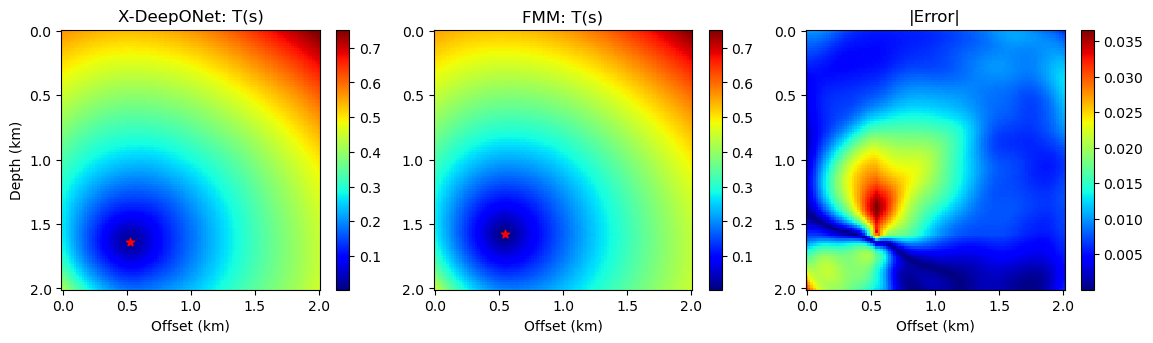

 trial 50 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-50.png


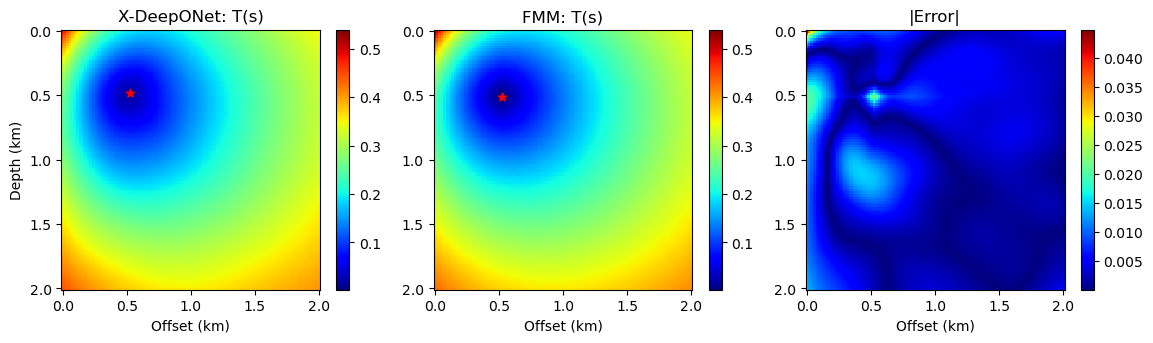

 trial 100 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-100.png


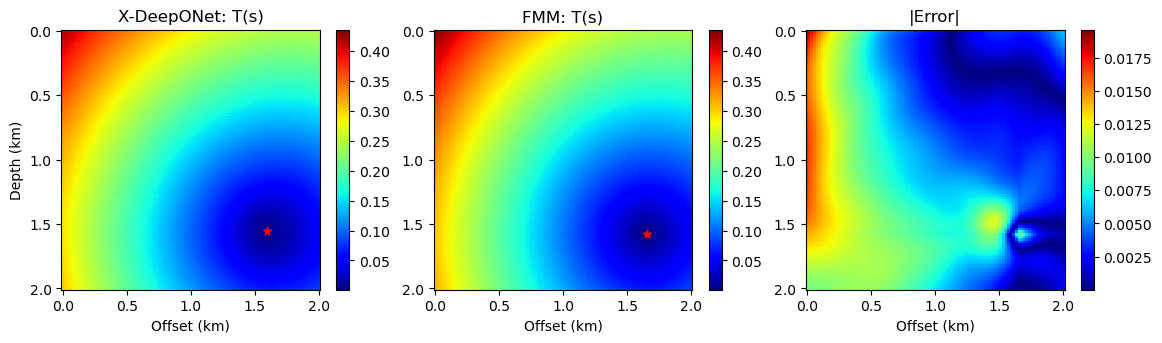

 trial 150 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-150.png


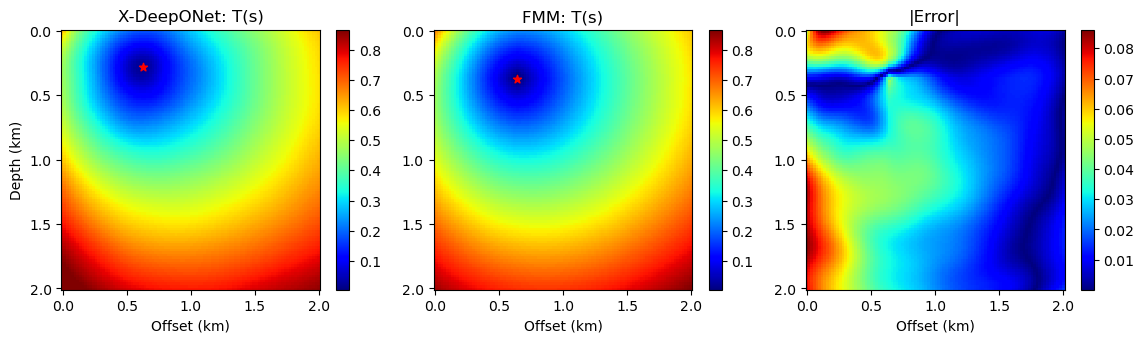

 trial 200 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-200.png


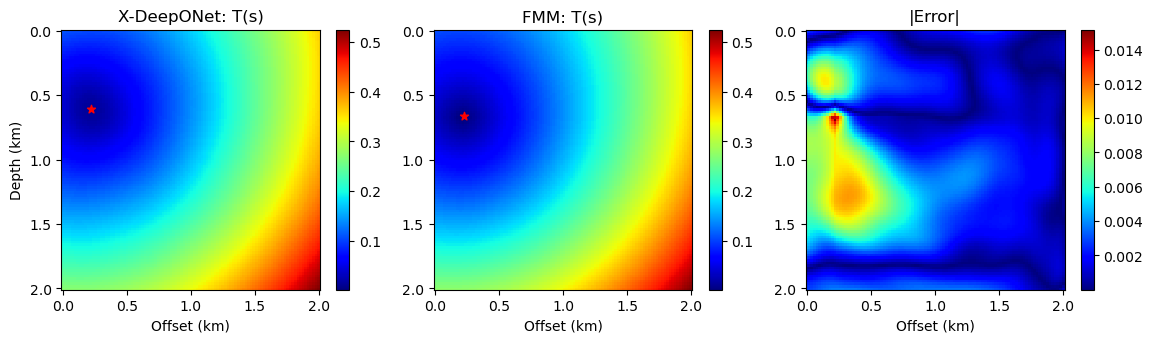

 trial 250 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-250.png


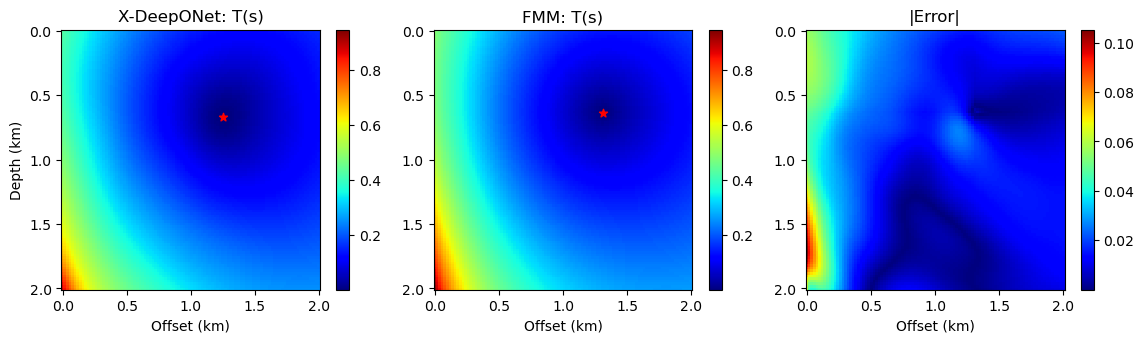

 trial 300 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-300.png


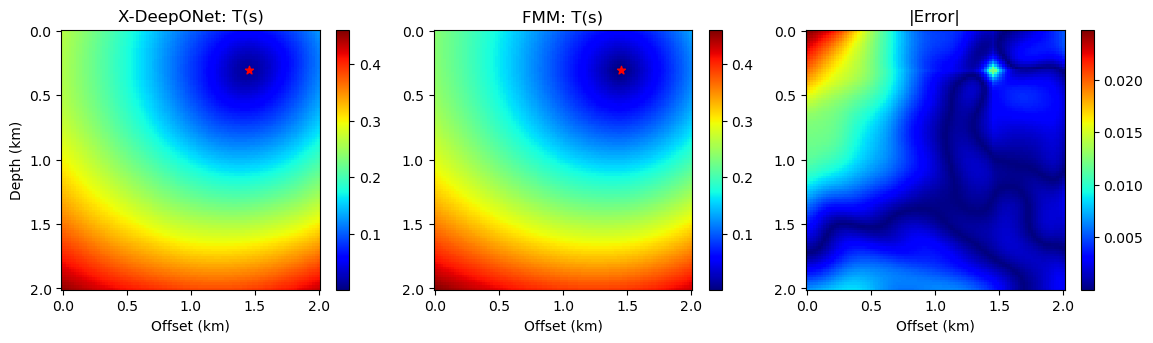

 trial 350 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-350.png


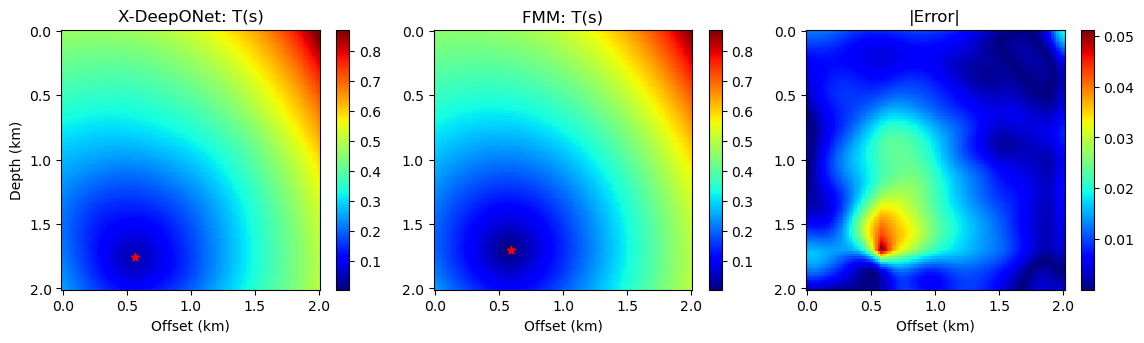

 trial 400 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-400.png


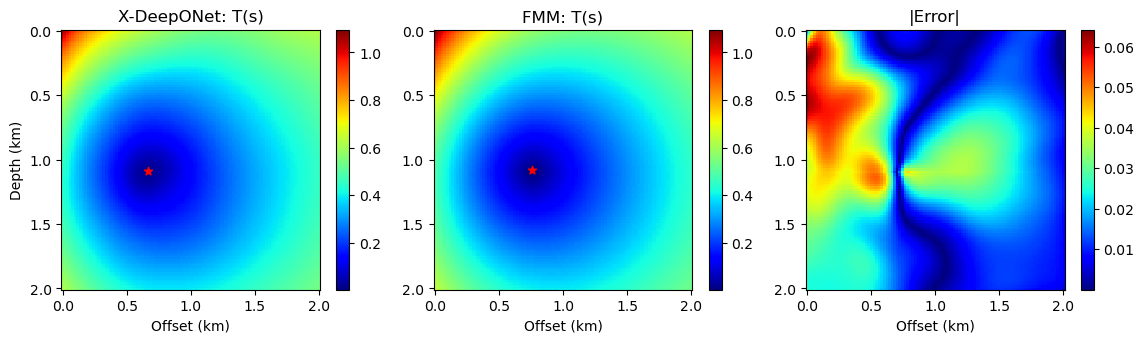

 trial 450 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-450.png


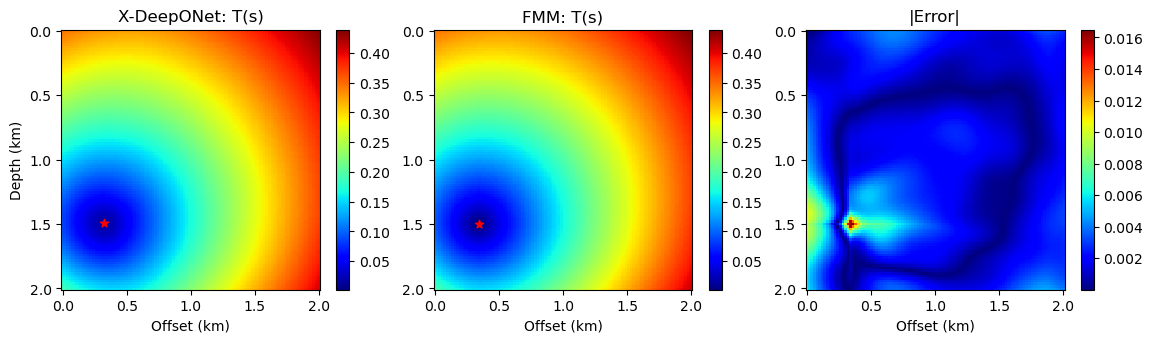

 trial 500 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-500.png


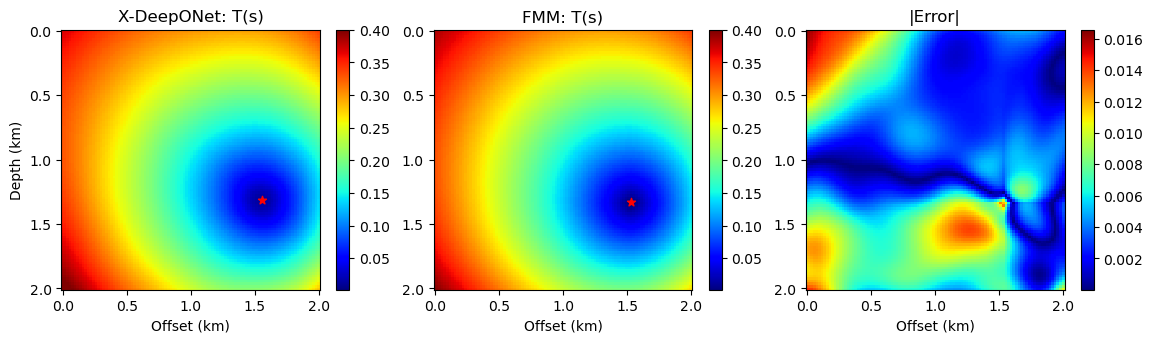

 trial 550 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-550.png


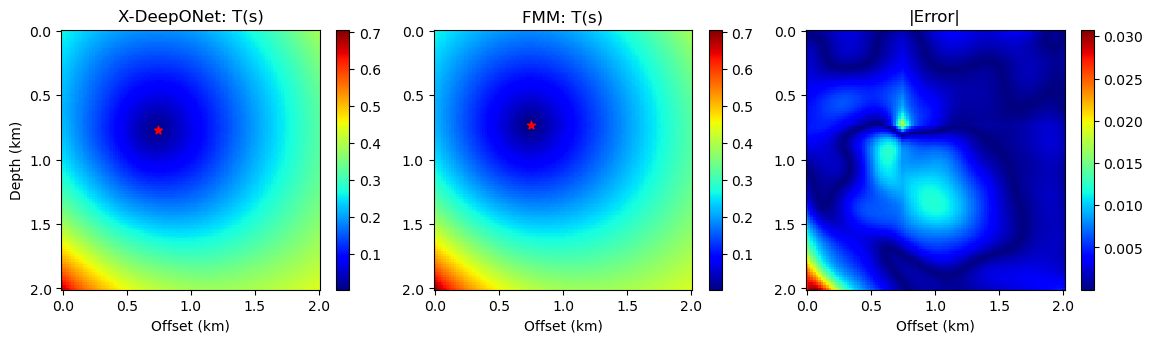

 trial 600 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-600.png


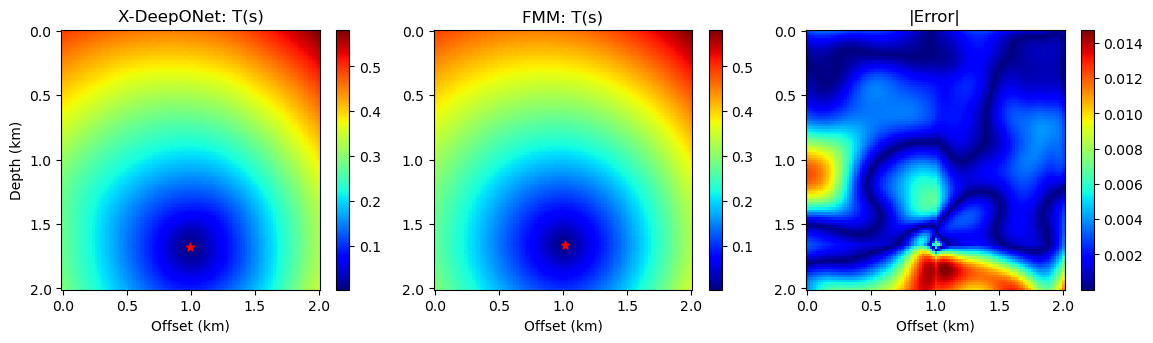

 trial 650 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-650.png


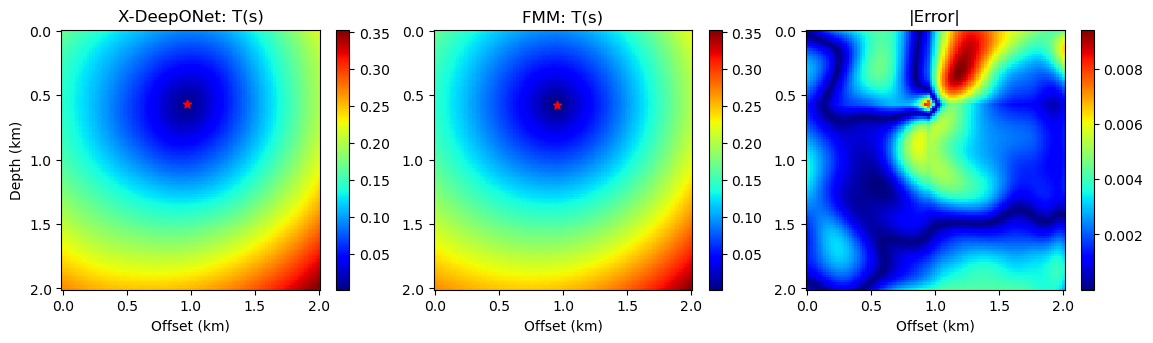

 trial 700 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-700.png


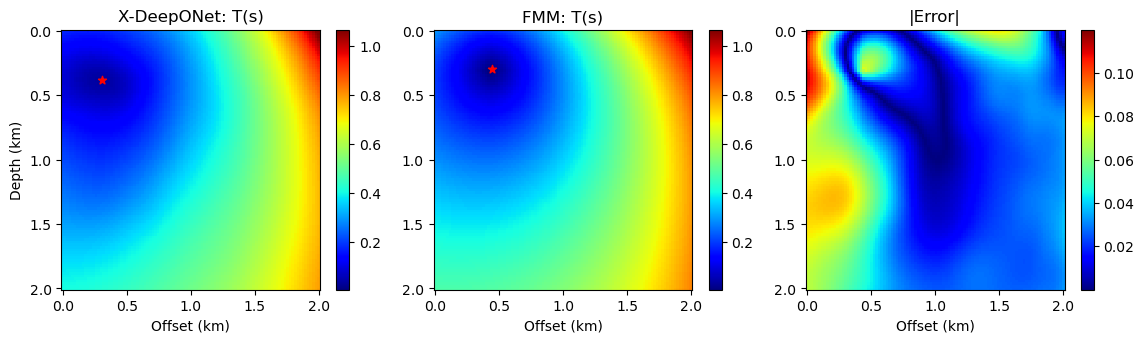

 trial 750 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-750.png


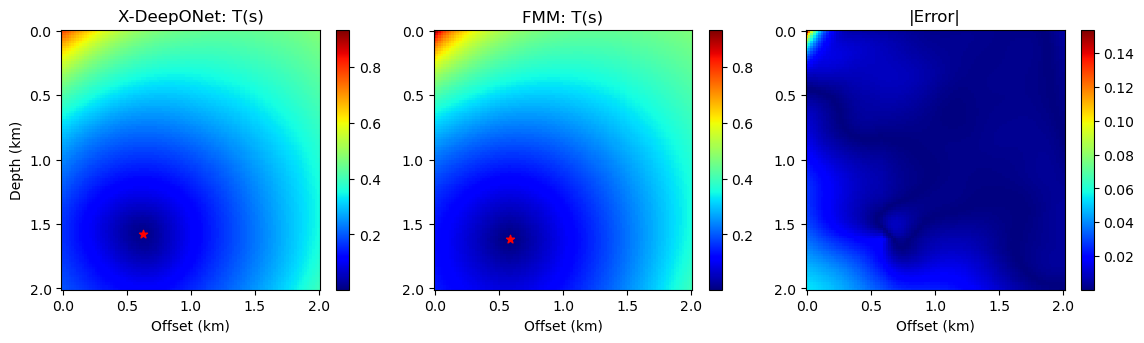

 trial 800 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-800.png


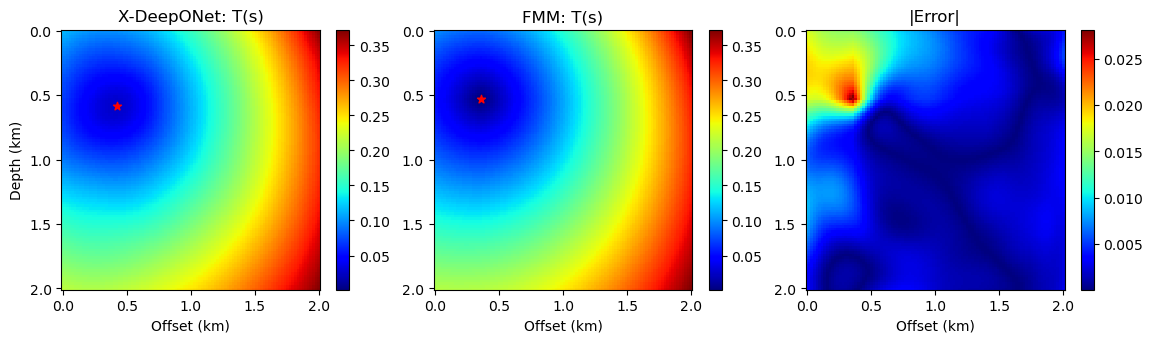

 trial 850 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-850.png


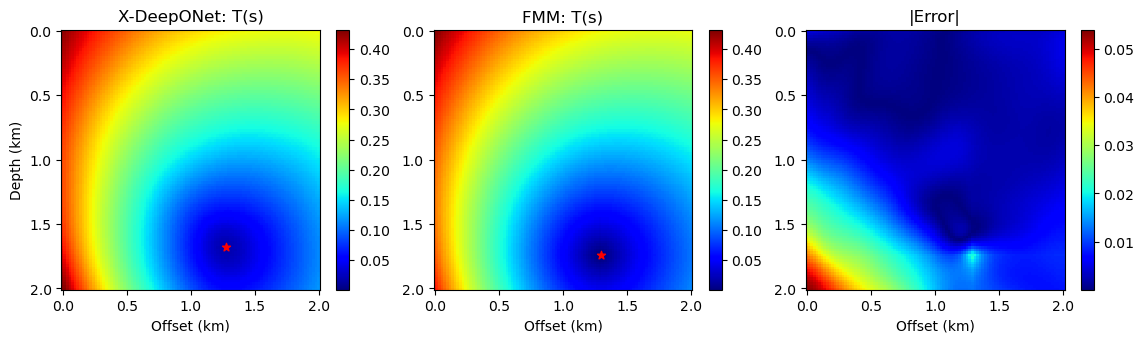

 trial 900 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-900.png


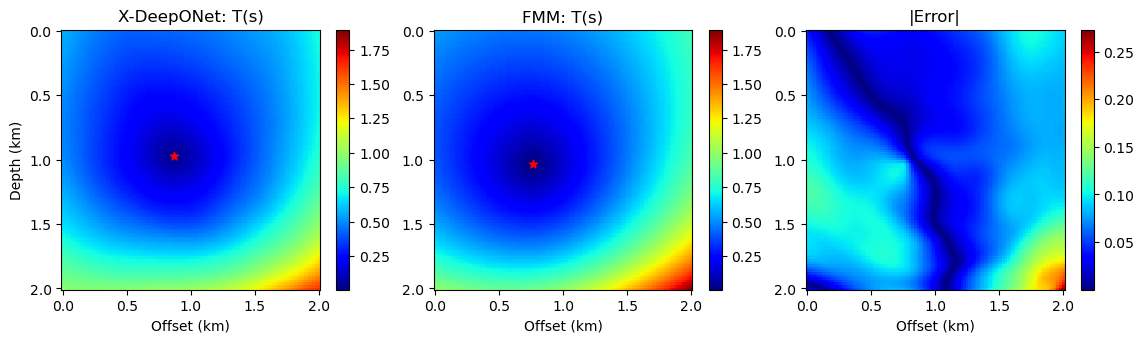

 trial 950 / 1000
Saving to:  PI_DeepXXXnet_Eikonal_source_identification_sciann_datadriven2/pred-950.png


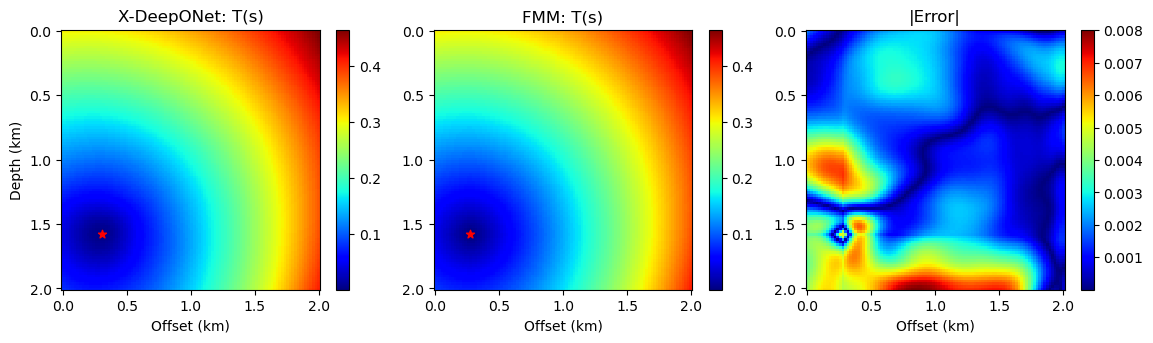

In [23]:
Nx, Ny = 100, 100

rmse_error = []
source_locs = []
source_error = []

np.random.seed(32324)

NUM_TRIAL = 1000
for i in range(NUM_TRIAL):        
    v_corners = list(np.random.uniform(VMIN, VMAX, (4,)))
    x_source, y_source = list(np.random.uniform(-0.8, 0.8, (2,)))
    
    test_data, vel_data, target_data = dg.generate_test_data(x_source, y_source, v_corners, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)

    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    v_test = vel_data.reshape(Nx, Ny)
    exact = target_data.reshape(Nx, Ny)
        
    pred = DON.eval_u(test_data).reshape(Nx, Ny)
    
    i_source, j_source = np.unravel_index(pred.argmin(), pred.shape)
    x_source_pred = x_test[i_source, j_source]
    y_source_pred = y_test[i_source, j_source]

    rmse_error.append(np.sqrt(np.mean((pred - exact)**2)))
    source_locs.append([x_source, y_source])
    
    source_error.append(
        [x_source-y_source_pred, y_source-x_source_pred]
    )


    if i % int(NUM_TRIAL/20) == 0:
        print(f' trial {i} / {NUM_TRIAL}')
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        # ax0 = ax[0].pcolor(x_test, y_test, v_test, cmap='seismic')
        # ax[0].set_title('velocity field')
        # ax[0].axis('off')
        # plt.colorbar(ax0, ax=ax[0])
        ax = [None, ax[0], ax[1], ax[2]]
        
        cust_pcolor(ax[1], x_test, y_test, pred, x_source_pred, y_source_pred, title='X-DeepONet: T(s)', 
                    cmap='jet', vmin=exact.min(), vmax=exact.max(), ylabel=True)
        cust_pcolor(ax[2], x_test, y_test, exact, y_source, x_source, title='FMM: T(s)', cmap='jet')
        cust_pcolor(ax[3], x_test, y_test, abs(pred - exact), title='|Error|', cmap='jet')
        plt.subplots_adjust(0.08, 0.2, 0.97, 0.85, 0.15, 0.15)
        print('Saving to: ', os.path.join(PATH_NAME, f'pred-{i}.png'))
        plt.savefig(os.path.join(PATH_NAME, f'pred-{i}.png'))
        plt.show()

    # raise ValueError

In [24]:
print(pred.min())
i_source, j_source = np.unravel_index(pred.argmin(), pred.shape)
pred[i_source, j_source]

0.008955553


0.008955553

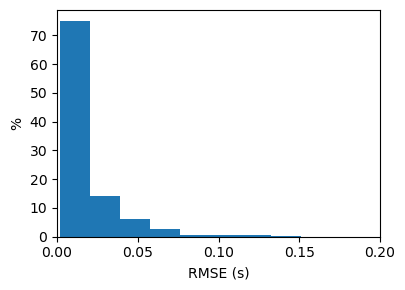

In [25]:
weights = np.ones(len(rmse_error)) / len(rmse_error) * 100
plt.figure(figsize=(4,3))
plt.hist(rmse_error, 20, weights=weights)
plt.xlabel('RMSE (s)')
plt.ylabel('%')
plt.tight_layout()
plt.xlim(0., 0.2)
plt.savefig(os.path.join(PATH_NAME, 'ekional_source_error_distribution.pdf'))

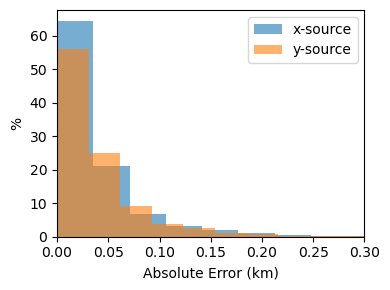

In [26]:
weights = np.ones(len(rmse_error)) / len(rmse_error) * 100
source_error = np.array(source_error)
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax = [ax]
# ax[0].hist(rmse_error, 20, weights=weights, alpha=0.6, label='RMSE(T)')
ax[0].hist(abs(source_error[:, 0]), 20, weights=weights, alpha=0.6, label='x-source')
ax[0].hist(abs(source_error[:, 1]), 20, weights=weights, alpha=0.6, label='y-source')
ax[0].set_xlabel('Absolute Error (km)')
# ax[0].set_xlim(-0.5, 0.5)
# ax[0].set_xlabel('y-source')
ax[0].set_xlim(0., 0.3)
ax[0].set_ylabel('%')
ax[0].set_ylabel('%')
plt.tight_layout()
plt.legend(loc='upper right')
# plt.show()
plt.savefig(os.path.join(PATH_NAME, 'ekional_XY-source_error_distribution.pdf'))

In [27]:
Nx, Ny = 100, 100

noise_vals =  [0.01, 0.1, 0.2, 0.5]
noise_error = []
noise_source_error = []
for noise in noise_vals:
    rmse_error2 = []
    source_error2 = []
    for i in range(1000):
        v_corners = list(np.random.uniform(VMIN, VMAX, (4,)))
        x_source, y_source = list(np.random.uniform(-0.9, 0.9, (2,)))

        test_data, vel_data, target_data = dg.generate_test_data(x_source, y_source, v_corners, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE, noise=noise)

        x_test = test_data[0].reshape(Nx, Ny)
        y_test = test_data[1].reshape(Nx, Ny)
        v_test = vel_data.reshape(Nx, Ny)
        exact = target_data.reshape(Nx, Ny)

        pred = DON.eval_u(test_data).reshape(Nx, Ny)
        
        i_source, j_source = np.unravel_index(pred.argmin(), pred.shape)
        x_source_pred = x_test[i_source, j_source]
        y_source_pred = y_test[i_source, j_source]
        
        rmse_error2.append(np.sqrt(np.mean((pred - exact)**2)))
        source_error2.append(
            [x_source-y_source_pred, y_source-x_source_pred]
        )

            
    print(f'done with noise = {noise}')
    noise_error.append(rmse_error2)
    noise_source_error.append(source_error2)

done with noise = 0.01
done with noise = 0.1
done with noise = 0.2
done with noise = 0.5


In [28]:
noise_source_error = np.array(noise_source_error)
noise_error = np.array(noise_error)
noise_Xsource_error = noise_source_error[:,:,0]
noise_Ysource_error = noise_source_error[:,:,1]

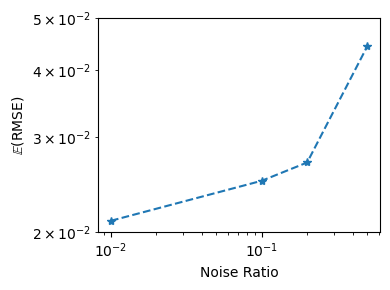

In [35]:
plt.figure(figsize=(4,3))
plt.loglog(noise_vals, np.mean(noise_error, axis=-1), '--*')
plt.xlabel('Noise Ratio')
plt.ylabel('$\mathbb{E}$(RMSE)')
plt.ylim(0.02, 0.05)
plt.tight_layout()
plt.savefig(os.path.join(PATH_NAME, 'ekional_source_noise_sensitivity.pdf'))

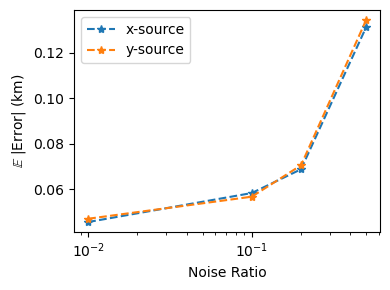

In [30]:
plt.figure(figsize=(4,3))
plt.semilogx(noise_vals, abs(noise_Xsource_error).mean(axis=-1), '--*', label='x-source')
plt.semilogx(noise_vals, abs(noise_Ysource_error).mean(axis=-1), '--*', label='y-source')
plt.xlabel('Noise Ratio')
plt.ylabel('$\mathbb{E}$ |Error| (km)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PATH_NAME, 'ekional_XY-source_noise_sensitivity.pdf'))

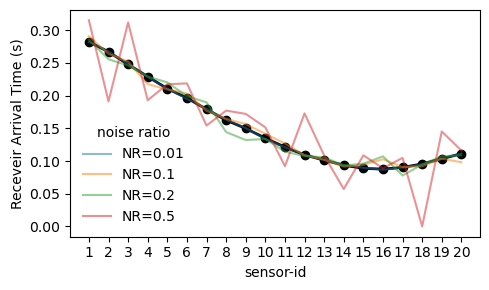

In [31]:
Nx, Ny = 100, 100

fig = plt.figure(figsize=(5, 3))
np.random.seed(1234)
v_corners = list(np.random.uniform(VMIN, VMAX, (4,)))
x_source, y_source = [0.5, 0.5]

sensor_id = np.arange(1, 21, 1)

test_data, vel_data, target_data = dg.generate_test_data(
    x_source, y_source, v_corners, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)
plt.plot(sensor_id, test_data[3][0, :], '-ok', lw=2, ms=6)


for noise in [0.01, 0.1, 0.2, 0.5]:
    for i in range(1):
        test_data, vel_data, target_data = dg.generate_test_data(
            x_source, y_source, v_corners, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE, noise=noise)
        plt.plot(sensor_id, test_data[3][0, :], '-', label=f'NR={noise}', alpha=0.5)
        

plt.ylabel('Receveir Arrival Time (s)')
plt.xlabel('sensor-id')
plt.xticks(np.arange(1, 21, 1))
plt.tight_layout()
plt.legend(title='noise ratio', loc='lower left', frameon=False)
plt.savefig(os.path.join(PATH_NAME, 'recevier-noise-realizations.pdf'))

In [32]:
test_data[2].shape

(10000, 100)

In [33]:
abs(noise_Xsource_error).std()

0.09177819677348265